In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import os

import geopandas as gpd
from matplotlib_map_utils.core.north_arrow import north_arrow
from matplotlib_map_utils.core.scale_bar import scale_bar
import statsmodels.api as sm

import matplotlib.pyplot as plt

import contextily as cx

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.compat import lzip
import numpy as np
import seaborn as sns
import statsmodels
from statsmodels.tools.tools import maybe_unwrap_results
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from typing import Type


In [2]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
pd.set_option('display.max_colwidth',None)

# 1. Read data

In [4]:
dfs = []

for chunk in pd.read_csv('data/04_processed/listing_processed.csv', chunksize=10000):
    dfs.append(chunk)

df = pd.concat(dfs)

In [5]:
# read cleaned PPD-zoopla data
ppd_zoopla = []

for chunk in pd.read_csv('c:\\Users\\2702471O\\OneDrive - University of Glasgow\\03Price modelling\\Zoopla_PPD_prj\\data\\zoopla_ppd_clean.csv', chunksize=10000):
    ppd_zoopla.append(chunk)

ppd_zoopla = pd.concat(ppd_zoopla)

C:\Users\2702471O\AppData\Local\Temp\ipykernel_20816\1557283771.py:4: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv('c:\\Users\\2702471O\\OneDrive - University of Glasgow\\03Price modelling\\Zoopla_PPD_prj\\data\\zoopla_ppd_clean.csv', chunksize=10000):
C:\Users\2702471O\AppData\Local\Temp\ipykernel_20816\1557283771.py:4: DtypeWarning: Columns (53) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv('c:\\Users\\2702471O\\OneDrive - University of Glasgow\\03Price modelling\\Zoopla_PPD_prj\\data\\zoopla_ppd_clean.csv', chunksize=10000):
C:\Users\2702471O\AppData\Local\Temp\ipykernel_20816\1557283771.py:4: DtypeWarning: Columns (53) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv('c:\\Users\\2702471O\\OneDrive - University of Glasgow\\03Price modelling\\Zoopla_PPD_prj\\data\\zoopla_ppd_clean.csv', chunksize=

In [6]:
ppd_zoopla['date'].min(), ppd_zoopla['date'].max(), ppd_zoopla.shape

('2017-09-01', '2023-10-26', (78772, 67))

## Sample selectoin

In [7]:
# drop new dwellings
df_existed = df[(df['NUMBER_HABITABLE_ROOMS']!='Not available') & (df['new_home']==False)]

In [8]:
# drop flats
df_existed = df_existed[df_existed['property_type_mapped']=='House']

## Neighbourhood visualisation

In [9]:
# visualise price and EPC by lsoa
lsoa_median_p = df_existed.groupby(by='lsoa11')['price'].median().reset_index()

In [10]:
df_existed['energy_efficient'] = df_existed['CURRENT_ENERGY_RATING'].apply(lambda x: 'High efficiency' if x in ['A','B','C','D'] else 'Low efficiency')

In [11]:
lsoa_epc = (
    df_existed.groupby('lsoa11')['energy_efficient']
      .value_counts(normalize=True)
      .rename('percentage')
      .reset_index()
)

In [12]:
lsoa_epc = lsoa_epc[lsoa_epc['energy_efficient']=='High efficiency']

In [13]:
neighs = pd.read_csv('data/04_processed/GM_lsoa_neighbourhood_data.csv')

In [14]:
gm = gpd.read_file('data/01_raw/Shapefile/GM_lsoa.shp')

In [15]:
gm = gm.set_index(keys='code')

In [16]:
gm = gm.join(lsoa_epc.set_index('lsoa11'),how='left').join(lsoa_median_p.set_index('lsoa11'),how='left').join(neighs.set_index('lsoa11'),how='left')

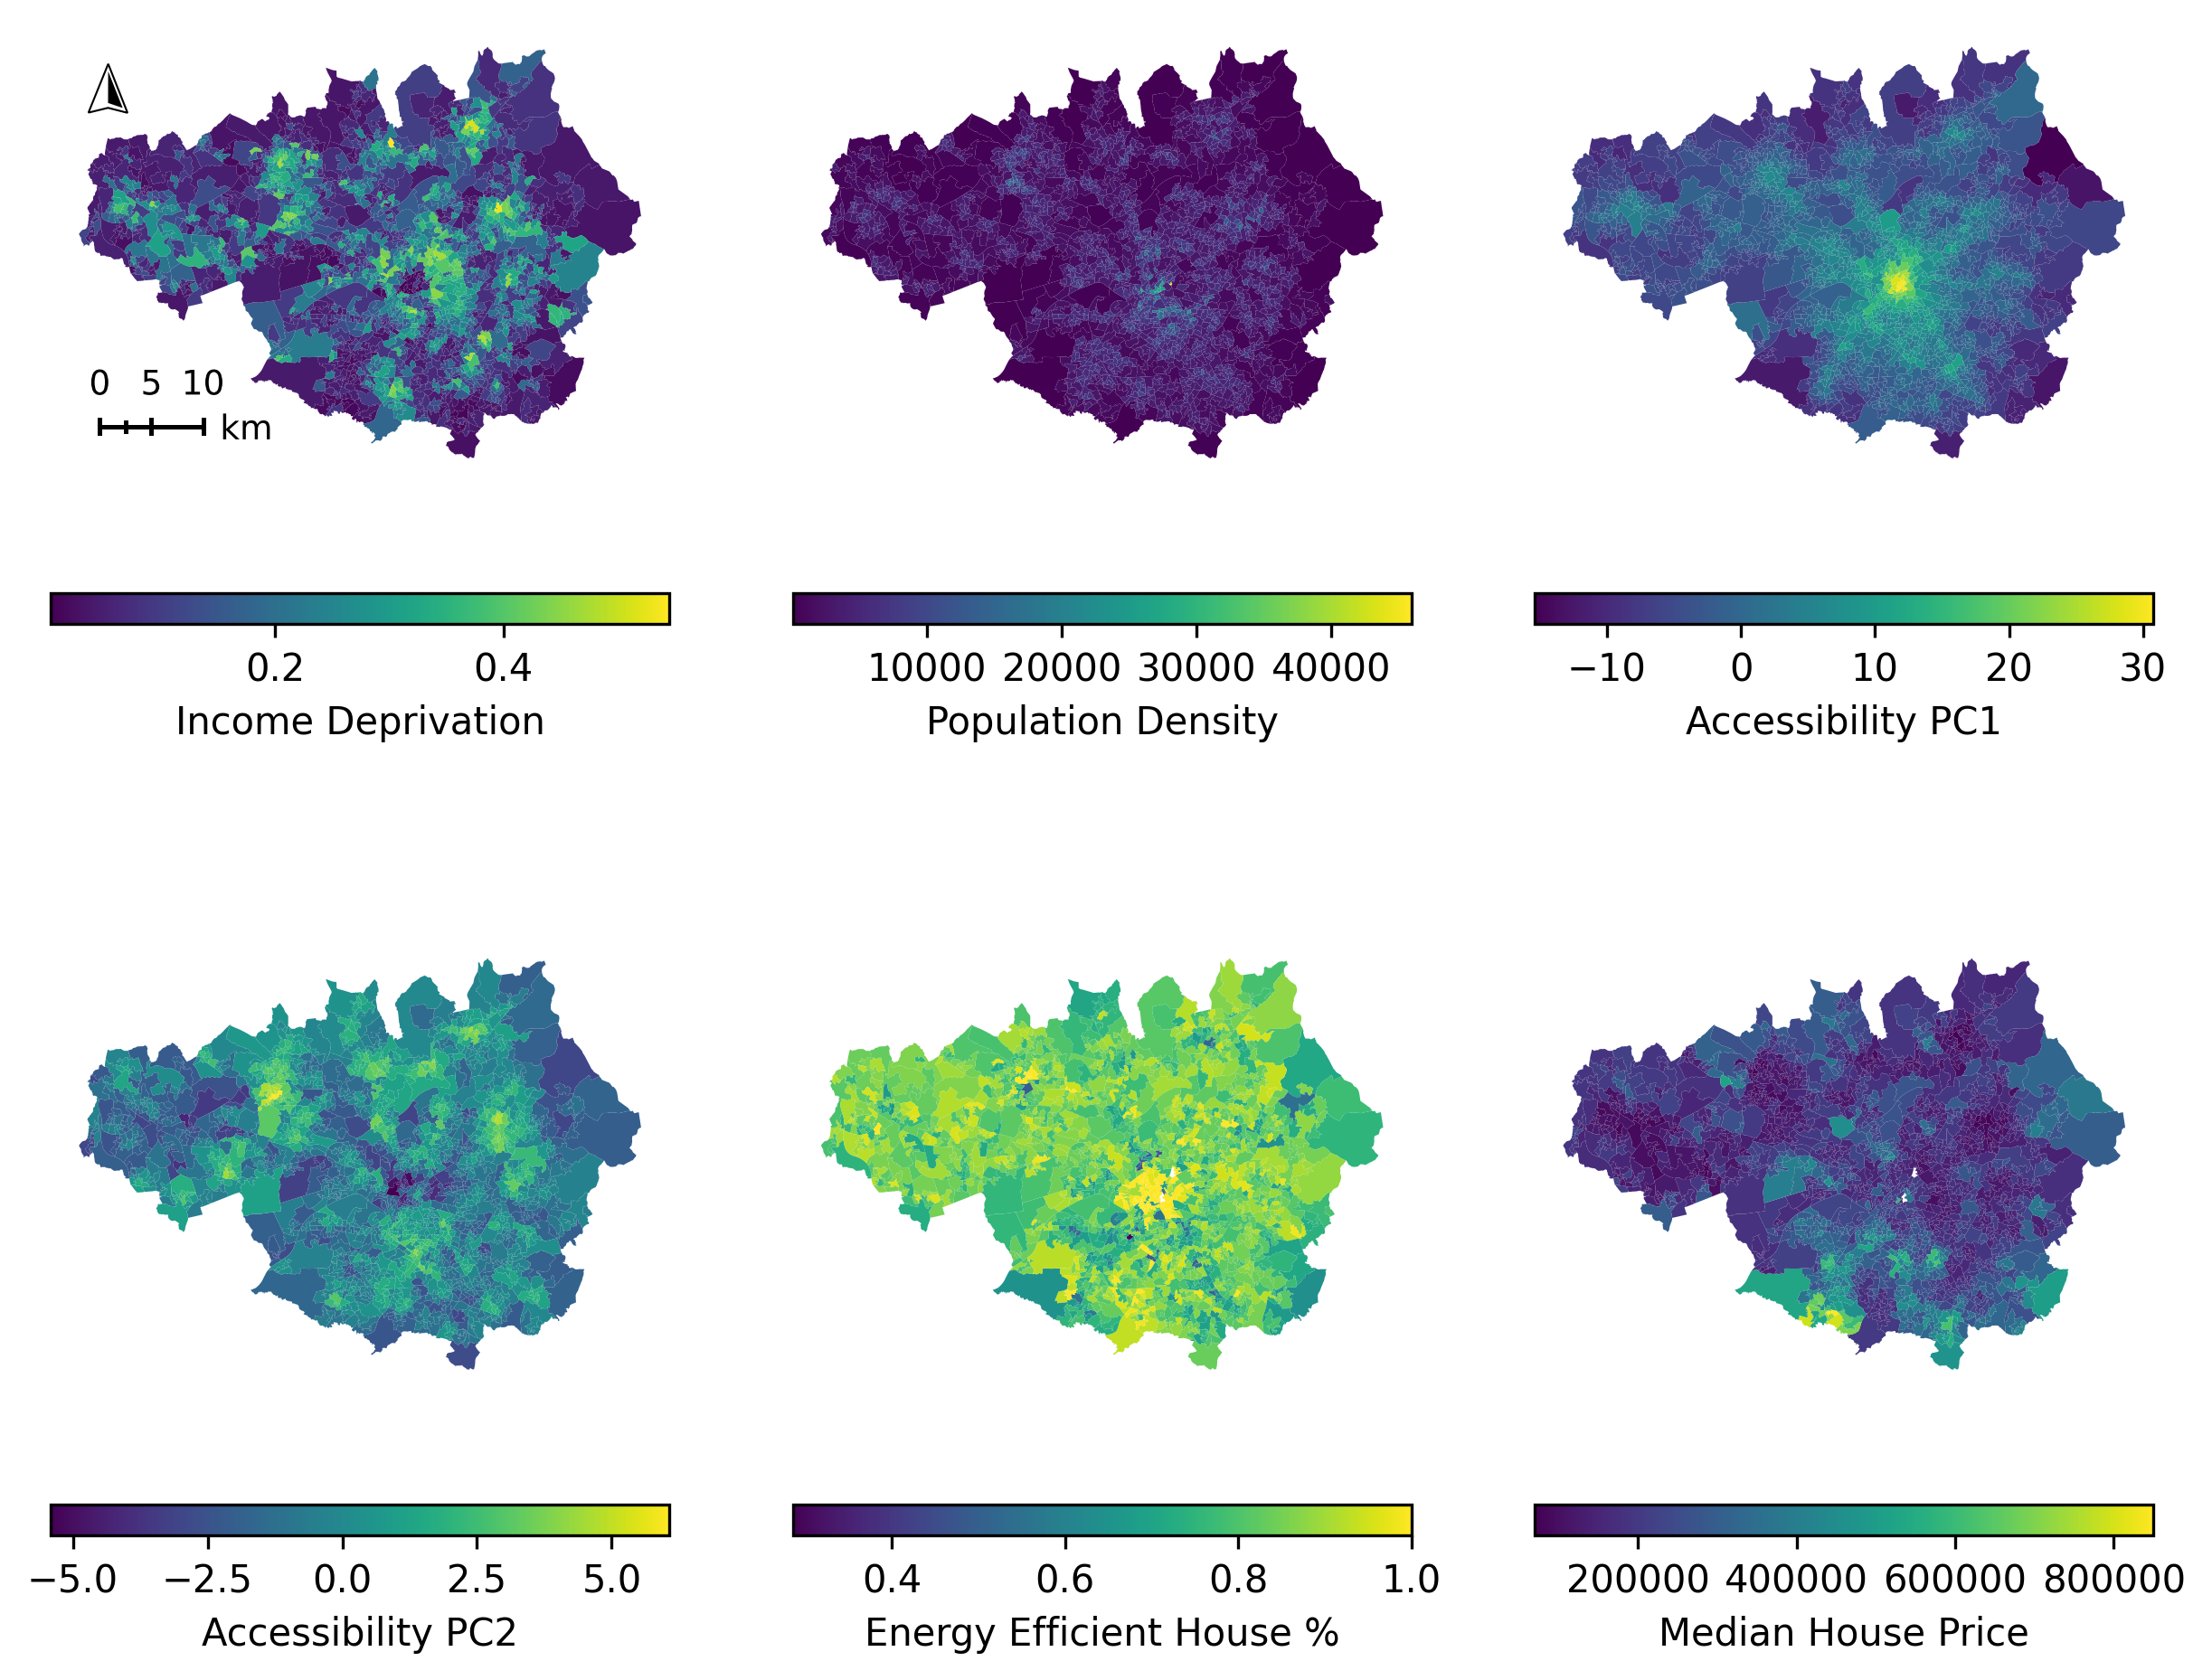

In [17]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(10,8),dpi=300)
gm.plot(column='income_score',ax=ax1,legend=True,
    legend_kwds={"label": "Income Deprivation", "orientation": "horizontal"})
north_arrow(
    ax1,
    location="upper left",
    scale=0.18,
    base={"linewidth": 0.5},
    rotation={"crs": gm.crs, "reference": "center"},
    shadow=False,  # this turns off the component
    label={"position": "bottom", "text": "", "fontsize": 1}
)
scale_bar(
    ax1, style="ticks",
    location="lower left", bar={"projection": gm.crs, "unit": "km", "tickwidth": 1.2, 'height':0.05,"max": 10,"major_div": 2,
        "tick_loc": "middle"}, labels={'fontsize':9, 'sep':0.1}, text={'fontsize':9}
)
ax1.set_axis_off()

gm.plot(column='pop_den_2020',ax=ax2,legend=True,
    legend_kwds={"label": "Population Density", "orientation": "horizontal"})
ax2.set_axis_off()

gm.plot(column='accessibility_PCA1',ax=ax3,legend=True,
    legend_kwds={"label": "Accessibility PC1", "orientation": "horizontal"})
ax3.set_axis_off()

gm.plot(column='accessibility_PCA2',ax=ax4,legend=True,
    legend_kwds={"label": "Accessibility PC2", "orientation": "horizontal"})
ax4.set_axis_off()

gm.plot(column='percentage',ax=ax5,legend=True,
    legend_kwds={"label": "Energy Efficient House %", "orientation": "horizontal"})
ax5.set_axis_off()

gm.plot(column='price',ax=ax6,legend=True,
    legend_kwds={"label": "Median House Price", "orientation": "horizontal"})
ax6.set_axis_off()

# 2. Variables preparation

In [19]:
# select duplicated rows on uprn
df_existed_duplicated = df_existed[df_existed['uprn'].duplicated(keep=False)]

In [20]:
# remap rooms
df_existed['rooms_mapped'] = df_existed['rooms_mapped'].replace(['1-2','3'],'1-3')

In [21]:
# energy crisis variable
df_existed['After_energy_crisis'] = df_existed['year_quarter'].apply(lambda x: True if pd.to_datetime(x) >= pd.Timestamp('2022-Q1') else False)

df_existed['After_energy_crisis_oct21'] = df_existed['year_quarter'].apply(lambda x: True if pd.to_datetime(x) >= pd.Timestamp('2021-Q4') else False)
df_existed['After_energy_crisis_feb22'] = df_existed['year_quarter'].apply(lambda x: True if pd.to_datetime(x) >= pd.Timestamp('2022-02-01') else False)

In [22]:
# log price
df_existed['log_price'] = np.log(df_existed['price'])

In [23]:
# filter out price lower than 30000
df_existed = df_existed[df_existed['price']>=30000]

## 2.1 MSOA vars

In [24]:
# weighted mean neighbourhood value for msoas
for neigh_var in ['log_popden_100','accessibility_PCA1', 'accessibility_PCA2','income_score']:
    new_var = neigh_var+'_msoa'
    df_existed[new_var] = df_existed[neigh_var].groupby(by=df_existed['msoa11']).transform('mean')

## 2.2 Dummy vars

In [25]:
df_dummy = pd.get_dummies(df_existed, columns=['tenure_mapped','PROPERTY_TYPE','rooms_mapped','epc_mapped','BUILT_FORM','age_mapped','new_home',
                                       'modern_kitchen', 'is_garages', 'is_basements', 'is_gardens','is_balconies',
                                    'year_quarter','LAD21NM'],dtype=float,drop_first=False)

In [26]:
df_dummy.columns = df_dummy.columns.str.replace(' ', '_')

## 2.3 Matched listings

In [27]:
# matched listings
# matched and all listings from same period
df_dummy_matched = df_dummy.join(ppd_zoopla[['listing_id','date']].set_index('listing_id'), how='inner', on='listing_id', rsuffix='pplist')

In [28]:
df_dummy_matched = df_dummy_matched[df_dummy_matched['date'] == df_dummy_matched['datepplist']]

In [29]:
# all listings same as matched listings date
df_dummy_match_all = df_dummy[df_dummy['date']<=df_dummy_matched['date'].max()]

In [30]:
df_dummy.shape, df_dummy_matched.shape, df_dummy_match_all.shape, df_dummy_matched['date'].max(), df_dummy_match_all['date'].max()

((170137, 125), (64292, 126), (149526, 125), '2023-10-24', '2023-10-24')

# 3. Set variables and outcomes

In [31]:
y = df_dummy['log_price']

In [32]:
X = df_dummy[[
    'tenure_mapped_leasehold',
              'PROPERTY_TYPE_Bungalow',
              'log_size',
              'rooms_mapped_4','rooms_mapped_5','rooms_mapped_6-7','rooms_mapped_8-10',
              'epc_mapped_AB','epc_mapped_C','epc_mapped_E','epc_mapped_FG',
             'age_mapped_before_1900',
              'age_mapped_1900-1929','age_mapped_1930-1949','age_mapped_1967-1982','age_mapped_1983-2002','age_mapped_2003-2011',
              'age_mapped_2012-2024',
            'BUILT_FORM_Detached','BUILT_FORM_Terraced',
            'modern_kitchen_True',
            'is_garages_True','is_basements_True','is_gardens_True',
              'income_score',
              'school_quality',
              'log_popden_100',
              'accessibility_PCA1','accessibility_PCA2',
              'year_quarter_2017-Q4','year_quarter_2018-Q1','year_quarter_2018-Q2','year_quarter_2018-Q3',
              'year_quarter_2018-Q4','year_quarter_2019-Q1','year_quarter_2019-Q2','year_quarter_2019-Q3',
              'year_quarter_2019-Q4','year_quarter_2020-Q1','year_quarter_2020-Q2','year_quarter_2020-Q3',
              'year_quarter_2020-Q4','year_quarter_2021-Q1','year_quarter_2021-Q2','year_quarter_2021-Q3',
              'year_quarter_2021-Q4','year_quarter_2022-Q1','year_quarter_2022-Q2','year_quarter_2022-Q3',
              'year_quarter_2022-Q4','year_quarter_2023-Q1','year_quarter_2023-Q2','year_quarter_2023-Q3',
              'year_quarter_2023-Q4','year_quarter_2024-Q1','year_quarter_2024-Q2',
              ]].copy()

# 4. Baseline OLS

## 4.1 Model fit

In [33]:
# 1. Add a constant (intercept) to the model
X = sm.add_constant(X) 

In [34]:
# 2. Fit the OLS regression model
model = sm.OLS(y, X)
results = model.fit(cov_type = "HC0")

In [35]:
# 3. Print the summary of the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     7658.
Date:                Wed, 03 Sep 2025   Prob (F-statistic):               0.00
Time:                        17:05:03   Log-Likelihood:                -15480.
No. Observations:              170137   AIC:                         3.107e+04
Df Residuals:                  170080   BIC:                         3.165e+04
Df Model:                          56                                         
Covariance Type:                  HC0                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [36]:
# variance of residuals
results.scale

np.float64(0.07025879526786517)

In [37]:
# transform coefficients to percentage
print('Price premium of band A/B compared to band D is: {} %'.format((10**results.summary2().tables[1].loc['epc_mapped_AB','Coef.'] - 1)*100))
print('Price premium of band C compared to band D is: {} %'.format((10**results.summary2().tables[1].loc['epc_mapped_C','Coef.'] - 1)*100))
print('Price premium of band E compared to band D is: {} %'.format((10**results.summary2().tables[1].loc['epc_mapped_E','Coef.'] - 1)*100))
print('Price premium of band F/G compared to band D is: {} %'.format((10**results.summary2().tables[1].loc['epc_mapped_FG','Coef.'] - 1)*100))

Price premium of band A/B compared to band D is: 4.897397152229388 %
Price premium of band C compared to band D is: 1.2010122540834223 %
Price premium of band E compared to band D is: -1.6784551704851158 %
Price premium of band F/G compared to band D is: -8.738489318740971 %


In [38]:
# monetary meaning based on median housing price
print('Median house price in Greater Manchester: {}'.format(df['price'].median()))
print('Monetary change of a median house with band A/B compared to D: {}'.format((10**results.summary2().tables[1].loc['epc_mapped_AB','Coef.'] - 1)*df['price'].median()))
print('Monetary change of a median house with band C compared to D: {}'.format((10**results.summary2().tables[1].loc['epc_mapped_C','Coef.'] - 1)*df['price'].median()))
print('Monetary change of a median house with band E compared to D: {}'.format((10**results.summary2().tables[1].loc['epc_mapped_E','Coef.'] - 1)*df['price'].median()))
print('Monetary change of a median house with band F/G compared to D: {}'.format((10**results.summary2().tables[1].loc['epc_mapped_FG','Coef.'] - 1)*df['price'].median()))

Median house price in Greater Manchester: 185000.0
Monetary change of a median house with band A/B compared to D: 9060.184731624367
Monetary change of a median house with band C compared to D: 2221.872670054331
Monetary change of a median house with band E compared to D: -3105.142065397464
Monetary change of a median house with band F/G compared to D: -16166.205239670799


## 4.2 Diagnostics

In [39]:
pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)

const                      746.784141
tenure_mapped_leasehold      1.057918
PROPERTY_TYPE_Bungalow       1.313593
log_size                     2.383378
rooms_mapped_4               3.292965
rooms_mapped_5               3.926091
rooms_mapped_6-7             4.231022
rooms_mapped_8-10            1.835226
epc_mapped_AB                1.020798
epc_mapped_C                 1.303342
epc_mapped_E                 1.119719
epc_mapped_FG                1.032430
age_mapped_before_1900       1.791451
age_mapped_1900-1929         2.573755
age_mapped_1930-1949         1.975255
age_mapped_1967-1982         1.701538
age_mapped_1983-2002         1.840436
age_mapped_2003-2011         1.468231
age_mapped_2012-2024         1.017256
BUILT_FORM_Detached          1.698248
BUILT_FORM_Terraced          1.937464
modern_kitchen_True          1.011809
is_garages_True              1.437278
is_basements_True            1.032641
is_gardens_True              1.188495
income_score                 1.385448
school_quali

In [40]:
# Homoscedasticity
homo_results = het_breuschpagan(results.resid, results.model.exog)

names = ['Lagrange multiplier statistic', 'p-value',
         'f-value', 'f p-value']

lzip(names, homo_results)

[('Lagrange multiplier statistic', np.float64(6401.868505573235)),
 ('p-value', np.float64(0.0)),
 ('f-value', np.float64(118.74903709795112)),
 ('f p-value', np.float64(0.0))]

# 5. Multilevel model

In [41]:
df_dummy = df_dummy.rename(columns=lambda col: col.replace('-', '_'))
df_dummy = df_dummy.rename(columns=lambda col: col.replace(' ', '_'))

df_dummy_matched = df_dummy_matched.rename(columns=lambda col: col.replace('-', '_'))
df_dummy_matched = df_dummy_matched.rename(columns=lambda col: col.replace(' ', '_'))

df_dummy_match_all = df_dummy_match_all.rename(columns=lambda col: col.replace('-', '_'))
df_dummy_match_all = df_dummy_match_all.rename(columns=lambda col: col.replace(' ', '_'))

## Empty model

In [42]:
# empty model
model_multi_emp = sm.MixedLM.from_formula(
    "log_price ~ 1",
    groups="lsoa11",  # Random intercept for neighborhoods
    data=df_dummy
)
result_multi_emp = model_multi_emp.fit()

# Print summary of the model
print(result_multi_emp.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_price  
No. Observations: 170137  Method:             REML       
No. Groups:       1671    Scale:              0.1111     
Min. group size:  1       Log-Likelihood:     -58510.2618
Max. group size:  403     Converged:          Yes        
Mean group size:  101.8                                  
---------------------------------------------------------
             Coef.  Std.Err.    z     P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept    12.206    0.010 1209.788 0.000 12.186 12.226
lsoa11 Var    0.168    0.018                             



In [43]:
# Extract variance components
def mlm_var(result):
    neighborhood_variance = result.cov_re.iloc[0, 0]  # Variance of random intercept (neighborhoods)
    residual_variance = result.scale  # Residual variance (houses)
    fixed_effects_variance = np.var(result.fittedvalues)  

    # Calculate Marginal and Conditional R^2 from these extracted variances:
    R2_m = fixed_effects_variance / (fixed_effects_variance + neighborhood_variance + residual_variance)
    R2_c = (fixed_effects_variance + neighborhood_variance) / (fixed_effects_variance + neighborhood_variance + residual_variance)

    # VPC for Level 2 (neighborhoods)
    vpc_neighborhood = neighborhood_variance / (neighborhood_variance + residual_variance)

    neighbourhood_per = neighborhood_variance / (fixed_effects_variance + neighborhood_variance + residual_variance)
    individual_per = fixed_effects_variance / (fixed_effects_variance + neighborhood_variance + residual_variance)

    return f'residual_variance:{residual_variance}, neighborhood_variance:{neighborhood_variance}, vpc_neighborhood:{vpc_neighborhood}, fixed_effects_variance:{fixed_effects_variance}, R2_m:{R2_m}, R2_c:{R2_c}, neighbourhood_per:{neighbourhood_per},individual_per:{individual_per}'

In [44]:
mlm_var(result_multi_emp)

'residual_variance:0.11109455230705113, neighborhood_variance:0.16790453180974446, vpc_neighborhood:0.6018103333251649, fixed_effects_variance:0.1337377374803624, R2_m:0.32402666901111615, R2_c:0.7308344046524583, neighbourhood_per:0.4068077356413422,individual_per:0.32402666901111615'

## MLM level 1

In [45]:
# MLM level 1
model_multi_1 = sm.MixedLM.from_formula(
    "log_price ~ tenure_mapped_leasehold+PROPERTY_TYPE_Bungalow+log_size+\
    rooms_mapped_4+rooms_mapped_5+rooms_mapped_6_7+rooms_mapped_8_10+\
              epc_mapped_AB+epc_mapped_C+epc_mapped_E+epc_mapped_FG+\
              age_mapped_before_1900+age_mapped_1900_1929+age_mapped_1930_1949+age_mapped_1967_1982+age_mapped_1983_2002+age_mapped_2003_2011+age_mapped_2012_2024+\
              BUILT_FORM_Detached+BUILT_FORM_Terraced+\
              modern_kitchen_True+is_garages_True+is_basements_True+is_gardens_True+\
              school_quality+\
              year_quarter_2017_Q4+year_quarter_2018_Q1+year_quarter_2018_Q2+year_quarter_2018_Q3+\
              year_quarter_2018_Q4+year_quarter_2019_Q1+year_quarter_2019_Q2+year_quarter_2019_Q3+\
              year_quarter_2019_Q4+year_quarter_2020_Q1+year_quarter_2020_Q2+year_quarter_2020_Q3+\
              year_quarter_2020_Q4+year_quarter_2021_Q1+year_quarter_2021_Q2+year_quarter_2021_Q3+\
              year_quarter_2021_Q4+year_quarter_2022_Q1+year_quarter_2022_Q2+year_quarter_2022_Q3+\
              year_quarter_2022_Q4+year_quarter_2023_Q1+year_quarter_2023_Q2+year_quarter_2023_Q3+\
              year_quarter_2023_Q4+year_quarter_2024_Q1+year_quarter_2024_Q2",
    groups="lsoa11",  # Random intercept for neighborhoods
    data=df_dummy
)
result_multi_1 = model_multi_1.fit()

# Print summary of the model
print(result_multi_1.summary())

               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     log_price 
No. Observations:     170137      Method:                 REML      
No. Groups:           1671        Scale:                  0.0311    
Min. group size:      1           Log-Likelihood:         49118.7067
Max. group size:      403         Converged:              Yes       
Mean group size:      101.8                                         
--------------------------------------------------------------------
                        Coef.  Std.Err.    z     P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                9.631    0.015  644.314 0.000  9.601  9.660
tenure_mapped_leasehold -0.006    0.001   -6.274 0.000 -0.008 -0.004
PROPERTY_TYPE_Bungalow   0.094    0.002   49.774 0.000  0.090  0.098
log_size                 0.496    0.002  199.576 0.000  0.491  0.501
rooms_mapped_4           0.013    0.002    7.990 0

In [46]:
mlm_var(result_multi_1)

'residual_variance:0.031068397008571544, neighborhood_variance:0.08780140493178495, vpc_neighborhood:0.7386350738250556, fixed_effects_variance:0.21454647795922457, R2_m:0.6434793106798565, R2_c:0.9068179963560004, neighbourhood_per:0.26333868567614377,individual_per:0.6434793106798565'

## MLM level 2

In [47]:
# MLM level 2
model_multi_2 = sm.MixedLM.from_formula(
    "log_price ~ income_score+\
              log_popden_100+\
              accessibility_PCA1+accessibility_PCA2",
    groups="lsoa11",  # Random intercept for neighborhoods
    data=df_dummy
)
result_multi_2 = model_multi_2.fit()

# Print summary of the model
print(result_multi_2.summary())

            Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  log_price  
No. Observations:    170137   Method:              REML       
No. Groups:          1671     Scale:               0.1111     
Min. group size:     1        Log-Likelihood:      -58040.5870
Max. group size:     403      Converged:           Yes        
Mean group size:     101.8                                    
--------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept          12.713    0.040 317.368 0.000 12.634 12.791
income_score       -2.406    0.071 -33.672 0.000 -2.546 -2.266
log_popden_100     -0.028    0.011  -2.567 0.010 -0.050 -0.007
accessibility_PCA1  0.012    0.001   7.868 0.000  0.009  0.014
accessibility_PCA2 -0.012    0.005  -2.477 0.013 -0.022 -0.003
lsoa11 Var          0.092    0.010                            



In [48]:
mlm_var(result_multi_2)

'residual_variance:0.11110353395185785, neighborhood_variance:0.09240997415397524, vpc_neighborhood:0.4540729262350453, fixed_effects_variance:0.13374436896592054, R2_m:0.39656410734467623, R2_c:0.6705680089179358, neighbourhood_per:0.2740039015732595,individual_per:0.39656410734467623'

## Full MLM

### EPC bands

In [49]:
# full MLM - EPC bands
model_multi = sm.MixedLM.from_formula(
    "log_price ~ tenure_mapped_leasehold+PROPERTY_TYPE_Bungalow+log_size+\
    rooms_mapped_4+rooms_mapped_5+rooms_mapped_6_7+rooms_mapped_8_10+\
              epc_mapped_AB+epc_mapped_C+epc_mapped_E+epc_mapped_FG+\
              age_mapped_before_1900+age_mapped_1900_1929+age_mapped_1930_1949+age_mapped_1967_1982+age_mapped_1983_2002+age_mapped_2003_2011+age_mapped_2012_2024+\
              BUILT_FORM_Detached+BUILT_FORM_Terraced+\
              modern_kitchen_True+is_garages_True+is_basements_True+is_gardens_True+\
              income_score+\
              school_quality+\
              log_popden_100+\
              accessibility_PCA1+accessibility_PCA2+\
              year_quarter_2017_Q4+year_quarter_2018_Q1+year_quarter_2018_Q2+year_quarter_2018_Q3+\
              year_quarter_2018_Q4+year_quarter_2019_Q1+year_quarter_2019_Q2+year_quarter_2019_Q3+\
              year_quarter_2019_Q4+year_quarter_2020_Q1+year_quarter_2020_Q2+year_quarter_2020_Q3+\
              year_quarter_2020_Q4+year_quarter_2021_Q1+year_quarter_2021_Q2+year_quarter_2021_Q3+\
              year_quarter_2021_Q4+year_quarter_2022_Q1+year_quarter_2022_Q2+year_quarter_2022_Q3+\
              year_quarter_2022_Q4+year_quarter_2023_Q1+year_quarter_2023_Q2+year_quarter_2023_Q3+\
              year_quarter_2023_Q4+year_quarter_2024_Q1+year_quarter_2024_Q2",
    groups="lsoa11",  # Random intercept for neighborhoods
    data=df_dummy
)
result_multi = model_multi.fit()

# Print summary of the model
print(result_multi.summary())

               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     log_price 
No. Observations:     170137      Method:                 REML      
No. Groups:           1671        Scale:                  0.0311    
Min. group size:      1           Log-Likelihood:         49524.1223
Max. group size:      403         Converged:              Yes       
Mean group size:      101.8                                         
--------------------------------------------------------------------
                        Coef.  Std.Err.    z     P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                9.923    0.033  301.041 0.000  9.858  9.987
tenure_mapped_leasehold -0.007    0.001   -6.718 0.000 -0.009 -0.005
PROPERTY_TYPE_Bungalow   0.094    0.002   49.675 0.000  0.090  0.097
log_size                 0.496    0.002  199.631 0.000  0.491  0.501
rooms_mapped_4           0.014    0.002    8.111 0

In [50]:
mlm_var(result_multi)

'residual_variance:0.031068143816566474, neighborhood_variance:0.052884241656858934, vpc_neighborhood:0.6299313754890158, fixed_effects_variance:0.21454953945877375, R2_m:0.7187542911406882, R2_c:0.8959197873728177, neighbourhood_per:0.1771654962321295,individual_per:0.7187542911406882'

### Full MLM diagnostic

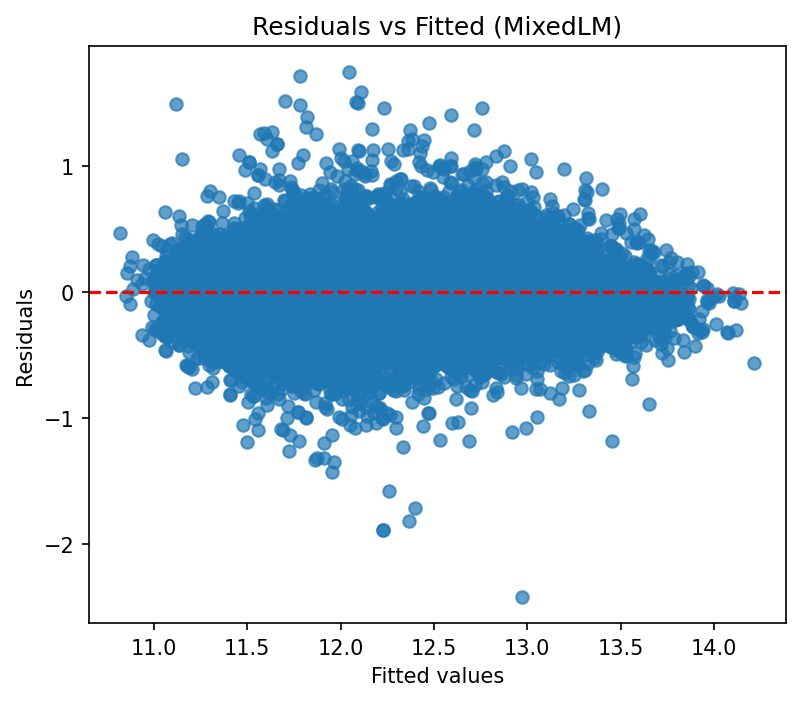

In [61]:
# Residual vs. fitted plot
fig,ax = plt.subplots(figsize=(6,5),dpi=150)
fitted = result_multi.fittedvalues
residuals = result_multi.resid

# Plot residuals vs fitted values
plt.scatter(fitted, residuals, alpha=0.7)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted (MixedLM)")
plt.show()

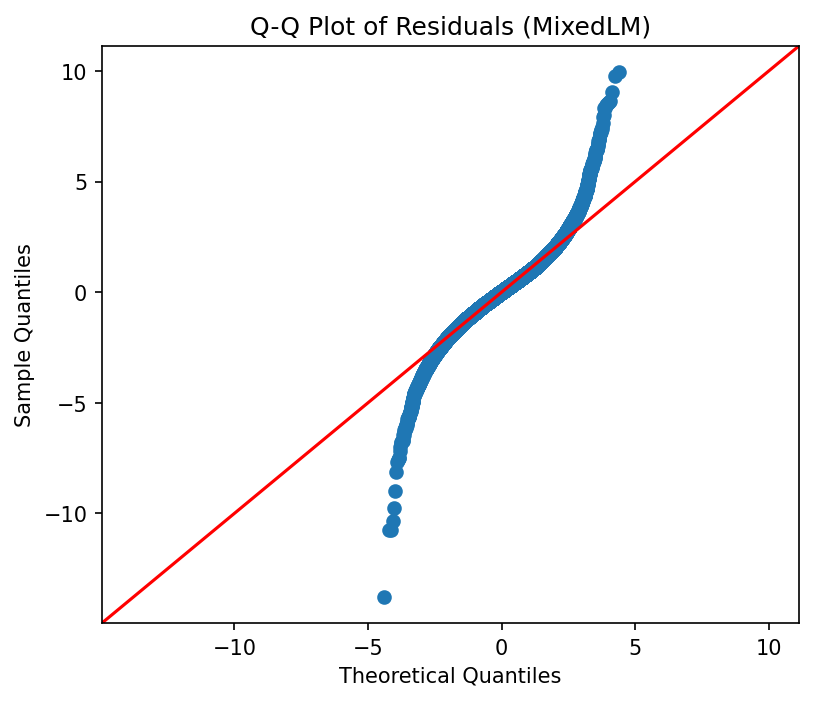

In [64]:
# Q-q plot
# fig,ax = plt.subplots(figsize=(6,5),dpi=150)
# sm.qqplot(residuals, line='45', fit=True)
# plt.title("Q-Q Plot of Residuals (MixedLM)")
# plt.show()

fig = plt.figure(figsize=(6, 5), dpi=150)

# Pass the figure into qqplot
ax = fig.add_subplot(111)
sm.qqplot(residuals, line="45", fit=True, ax=ax)

plt.title("Q-Q Plot of Residuals (MixedLM)")
plt.show()

### EPC score

In [ ]:
# full MLM - EPC score
model_multi = sm.MixedLM.from_formula(
    "log_price ~ tenure_mapped_leasehold+PROPERTY_TYPE_Bungalow+log_size+\
    rooms_mapped_4+rooms_mapped_5+rooms_mapped_6_7+rooms_mapped_8_10+\
              CURRENT_ENERGY_EFFICIENCY+\
              age_mapped_before_1900+age_mapped_1900_1929+age_mapped_1930_1949+age_mapped_1967_1982+age_mapped_1983_2002+age_mapped_2003_2011+age_mapped_2012_2024+\
              BUILT_FORM_Detached+BUILT_FORM_Terraced+\
              modern_kitchen_True+is_garages_True+is_basements_True+is_gardens_True+\
              income_score+\
              school_quality+\
              log_popden_100+\
              accessibility_PCA1+accessibility_PCA2+\
              year_quarter_2017_Q4+year_quarter_2018_Q1+year_quarter_2018_Q2+year_quarter_2018_Q3+\
              year_quarter_2018_Q4+year_quarter_2019_Q1+year_quarter_2019_Q2+year_quarter_2019_Q3+\
              year_quarter_2019_Q4+year_quarter_2020_Q1+year_quarter_2020_Q2+year_quarter_2020_Q3+\
              year_quarter_2020_Q4+year_quarter_2021_Q1+year_quarter_2021_Q2+year_quarter_2021_Q3+\
              year_quarter_2021_Q4+year_quarter_2022_Q1+year_quarter_2022_Q2+year_quarter_2022_Q3+\
              year_quarter_2022_Q4+year_quarter_2023_Q1+year_quarter_2023_Q2+year_quarter_2023_Q3+\
              year_quarter_2023_Q4+year_quarter_2024_Q1+year_quarter_2024_Q2",
    groups="lsoa11",  # Random intercept for neighborhoods
    data=df_dummy
)
result_multi = model_multi.fit()

# Print summary of the model
print(result_multi.summary())

                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     log_price 
No. Observations:       170137      Method:                 REML      
No. Groups:             1671        Scale:                  0.0310    
Min. group size:        1           Log-Likelihood:         49604.0927
Max. group size:        403         Converged:              Yes       
Mean group size:        101.8                                         
----------------------------------------------------------------------
                          Coef.  Std.Err.    z     P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                  9.842    0.033  297.250 0.000  9.777  9.907
tenure_mapped_leasehold   -0.007    0.001   -6.807 0.000 -0.009 -0.005
PROPERTY_TYPE_Bungalow     0.094    0.002   49.826 0.000  0.090  0.098
log_size                   0.496    0.002  200.122 0.000  0.492  0.501
rooms_mapped_4         

In [ ]:
mlm_var(result_multi)

'residual_variance:0.031042362060651016, neighborhood_variance:0.05290210158471103, vpc_neighborhood:0.6302035808842039, fixed_effects_variance:0.21457500985114217, R2_m:0.7187973613173847, R2_c:0.8960122711692557, neighbourhood_per:0.17721490985187113,individual_per:0.7187973613173847'

In [ ]:
result_multi.aic

### Robustness check - Matched and all listings

In [ ]:
model_multi_match = sm.MixedLM.from_formula(
    "log_price ~ tenure_mapped_leasehold+PROPERTY_TYPE_Bungalow+log_size+\
    rooms_mapped_4+rooms_mapped_5+rooms_mapped_6_7+rooms_mapped_8_10+\
              epc_mapped_AB+epc_mapped_C+epc_mapped_E+epc_mapped_FG+\
              age_mapped_before_1900+age_mapped_1900_1929+age_mapped_1930_1949+age_mapped_1967_1982+age_mapped_1983_2002+age_mapped_2003_2011+age_mapped_2012_2024+\
              BUILT_FORM_Detached+BUILT_FORM_Terraced+\
              modern_kitchen_True+is_garages_True+is_basements_True+is_gardens_True+\
              income_score+\
              school_quality+\
              log_popden_100+\
              accessibility_PCA1+accessibility_PCA2+\
              year_quarter_2017_Q4+year_quarter_2018_Q1+year_quarter_2018_Q2+year_quarter_2018_Q3+\
              year_quarter_2018_Q4+year_quarter_2019_Q1+year_quarter_2019_Q2+year_quarter_2019_Q3+\
              year_quarter_2019_Q4+year_quarter_2020_Q1+year_quarter_2020_Q2+year_quarter_2020_Q3+\
              year_quarter_2020_Q4+year_quarter_2021_Q1+year_quarter_2021_Q2+year_quarter_2021_Q3+\
              year_quarter_2021_Q4+year_quarter_2022_Q1+year_quarter_2022_Q2+year_quarter_2022_Q3+\
              year_quarter_2022_Q4+year_quarter_2023_Q1+year_quarter_2023_Q2+year_quarter_2023_Q3+\
              year_quarter_2023_Q4",
    groups="lsoa11",  # Random intercept for neighborhoods
    data=df_dummy_matched
)
result_multi_match = model_multi_match.fit()

# Print summary of the model
print(result_multi_match.summary())

               Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    log_price 
No. Observations:      64292      Method:                REML      
No. Groups:            1655       Scale:                 0.0250    
Min. group size:       1          Log-Likelihood:        23749.7988
Max. group size:       149        Converged:             Yes       
Mean group size:       38.8                                        
-------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept               10.018    0.035 282.530 0.000  9.948 10.087
tenure_mapped_leasehold  0.000    0.001   0.221 0.825 -0.003  0.003
PROPERTY_TYPE_Bungalow   0.088    0.003  32.515 0.000  0.083  0.094
log_size                 0.483    0.004 129.576 0.000  0.476  0.490
rooms_mapped_4           0.009    0.002   3.638 0.000  0.004  0

In [ ]:
model_multi_match = sm.MixedLM.from_formula(
    "log_price ~ tenure_mapped_leasehold+PROPERTY_TYPE_Bungalow+log_size+\
    rooms_mapped_4+rooms_mapped_5+rooms_mapped_6_7+rooms_mapped_8_10+\
              CURRENT_ENERGY_EFFICIENCY+\
              age_mapped_before_1900+age_mapped_1900_1929+age_mapped_1930_1949+age_mapped_1967_1982+age_mapped_1983_2002+age_mapped_2003_2011+age_mapped_2012_2024+\
              BUILT_FORM_Detached+BUILT_FORM_Terraced+\
              modern_kitchen_True+is_garages_True+is_basements_True+is_gardens_True+\
              income_score+\
              school_quality+\
              log_popden_100+\
              accessibility_PCA1+accessibility_PCA2+\
              year_quarter_2017_Q4+year_quarter_2018_Q1+year_quarter_2018_Q2+year_quarter_2018_Q3+\
              year_quarter_2018_Q4+year_quarter_2019_Q1+year_quarter_2019_Q2+year_quarter_2019_Q3+\
              year_quarter_2019_Q4+year_quarter_2020_Q1+year_quarter_2020_Q2+year_quarter_2020_Q3+\
              year_quarter_2020_Q4+year_quarter_2021_Q1+year_quarter_2021_Q2+year_quarter_2021_Q3+\
              year_quarter_2021_Q4+year_quarter_2022_Q1+year_quarter_2022_Q2+year_quarter_2022_Q3+\
              year_quarter_2022_Q4+year_quarter_2023_Q1+year_quarter_2023_Q2+year_quarter_2023_Q3+\
              year_quarter_2023_Q4",
    groups="lsoa11",  # Random intercept for neighborhoods
    data=df_dummy_matched
)
result_multi_match = model_multi_match.fit()

# Print summary of the model
print(result_multi_match.summary())

                Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     log_price 
No. Observations:      64292       Method:                 REML      
No. Groups:            1655        Scale:                  0.0249    
Min. group size:       1           Log-Likelihood:         23788.9349
Max. group size:       149         Converged:              Yes       
Mean group size:       38.8                                          
---------------------------------------------------------------------
                          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  9.937    0.036 277.970 0.000  9.867 10.007
tenure_mapped_leasehold    0.000    0.001   0.121 0.904 -0.003  0.003
PROPERTY_TYPE_Bungalow     0.089    0.003  32.656 0.000  0.083  0.094
log_size                   0.483    0.004 129.905 0.000  0.476  0.491
rooms_mapped_4             0.009    

In [ ]:
model_multi_all = sm.MixedLM.from_formula(
    "log_price ~ tenure_mapped_leasehold+PROPERTY_TYPE_Bungalow+log_size+\
    rooms_mapped_4+rooms_mapped_5+rooms_mapped_6_7+rooms_mapped_8_10+\
              epc_mapped_AB+epc_mapped_C+epc_mapped_E+epc_mapped_FG+\
              age_mapped_before_1900+age_mapped_1900_1929+age_mapped_1930_1949+age_mapped_1967_1982+age_mapped_1983_2002+age_mapped_2003_2011+age_mapped_2012_2024+\
              BUILT_FORM_Detached+BUILT_FORM_Terraced+\
              modern_kitchen_True+is_garages_True+is_basements_True+is_gardens_True+\
              income_score+\
              school_quality+\
              log_popden_100+\
              accessibility_PCA1+accessibility_PCA2+\
              year_quarter_2017_Q4+year_quarter_2018_Q1+year_quarter_2018_Q2+year_quarter_2018_Q3+\
              year_quarter_2018_Q4+year_quarter_2019_Q1+year_quarter_2019_Q2+year_quarter_2019_Q3+\
              year_quarter_2019_Q4+year_quarter_2020_Q1+year_quarter_2020_Q2+year_quarter_2020_Q3+\
              year_quarter_2020_Q4+year_quarter_2021_Q1+year_quarter_2021_Q2+year_quarter_2021_Q3+\
              year_quarter_2021_Q4+year_quarter_2022_Q1+year_quarter_2022_Q2+year_quarter_2022_Q3+\
              year_quarter_2022_Q4+year_quarter_2023_Q1+year_quarter_2023_Q2+year_quarter_2023_Q3+\
              year_quarter_2023_Q4",
    groups="lsoa11",  # Random intercept for neighborhoods
    data=df_dummy_match_all
)
result_multi_all = model_multi_all.fit()

# Print summary of the model
print(result_multi_all.summary())

               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     log_price 
No. Observations:     149526      Method:                 REML      
No. Groups:           1671        Scale:                  0.0312    
Min. group size:      1           Log-Likelihood:         42854.6621
Max. group size:      366         Converged:              Yes       
Mean group size:      89.5                                          
--------------------------------------------------------------------
                        Coef.  Std.Err.    z     P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                9.978    0.033  300.397 0.000  9.913 10.043
tenure_mapped_leasehold -0.006    0.001   -5.233 0.000 -0.008 -0.004
PROPERTY_TYPE_Bungalow   0.095    0.002   46.739 0.000  0.091  0.099
log_size                 0.493    0.003  185.192 0.000  0.488  0.498
rooms_mapped_4           0.013    0.002    7.311 0

In [ ]:
model_multi_all = sm.MixedLM.from_formula(
    "log_price ~ tenure_mapped_leasehold+PROPERTY_TYPE_Bungalow+log_size+\
    rooms_mapped_4+rooms_mapped_5+rooms_mapped_6_7+rooms_mapped_8_10+\
              CURRENT_ENERGY_EFFICIENCY+\
              age_mapped_before_1900+age_mapped_1900_1929+age_mapped_1930_1949+age_mapped_1967_1982+age_mapped_1983_2002+age_mapped_2003_2011+age_mapped_2012_2024+\
              BUILT_FORM_Detached+BUILT_FORM_Terraced+\
              modern_kitchen_True+is_garages_True+is_basements_True+is_gardens_True+\
              income_score+\
              school_quality+\
              log_popden_100+\
              accessibility_PCA1+accessibility_PCA2+\
              year_quarter_2017_Q4+year_quarter_2018_Q1+year_quarter_2018_Q2+year_quarter_2018_Q3+\
              year_quarter_2018_Q4+year_quarter_2019_Q1+year_quarter_2019_Q2+year_quarter_2019_Q3+\
              year_quarter_2019_Q4+year_quarter_2020_Q1+year_quarter_2020_Q2+year_quarter_2020_Q3+\
              year_quarter_2020_Q4+year_quarter_2021_Q1+year_quarter_2021_Q2+year_quarter_2021_Q3+\
              year_quarter_2021_Q4+year_quarter_2022_Q1+year_quarter_2022_Q2+year_quarter_2022_Q3+\
              year_quarter_2022_Q4+year_quarter_2023_Q1+year_quarter_2023_Q2+year_quarter_2023_Q3+\
              year_quarter_2023_Q4",
    groups="lsoa11",  # Random intercept for neighborhoods
    data=df_dummy_match_all
)
result_multi_all = model_multi_all.fit()

# Print summary of the model
print(result_multi_all.summary())

                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     log_price 
No. Observations:       149526      Method:                 REML      
No. Groups:             1671        Scale:                  0.0311    
Min. group size:        1           Log-Likelihood:         42928.0051
Max. group size:        366         Converged:              Yes       
Mean group size:        89.5                                          
----------------------------------------------------------------------
                          Coef.  Std.Err.    z     P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                  9.899    0.033  296.515 0.000  9.833  9.964
tenure_mapped_leasehold   -0.006    0.001   -5.324 0.000 -0.008 -0.004
PROPERTY_TYPE_Bungalow     0.095    0.002   46.900 0.000  0.091  0.099
log_size                   0.493    0.003  185.628 0.000  0.488  0.499
rooms_mapped_4         

# 6. Interactive var - energy crisis


## 6.1 OLS

In [92]:
formula = 'log_price ~ tenure_mapped_leasehold+PROPERTY_TYPE_Bungalow+log_size+\
    rooms_mapped_4+rooms_mapped_5+rooms_mapped_6_7+rooms_mapped_8_10+\
              epc_mapped_AB+epc_mapped_C+epc_mapped_E+epc_mapped_FG+\
              age_mapped_before_1900+age_mapped_1900_1929+age_mapped_1930_1949+age_mapped_1967_1982+age_mapped_1983_2002+age_mapped_2003_2011+age_mapped_2012_2024+\
              BUILT_FORM_Detached+BUILT_FORM_Terraced+\
              modern_kitchen_True+is_garages_True+is_basements_True+is_gardens_True+\
              income_score+\
              school_quality+\
              log_popden_100+\
              accessibility_PCA1+accessibility_PCA2+\
              year_quarter_2017_Q4+year_quarter_2018_Q1+year_quarter_2018_Q2+year_quarter_2018_Q3+\
              year_quarter_2018_Q4+year_quarter_2019_Q1+year_quarter_2019_Q2+year_quarter_2019_Q3+\
              year_quarter_2019_Q4+year_quarter_2020_Q1+year_quarter_2020_Q2+year_quarter_2020_Q3+\
              year_quarter_2020_Q4+year_quarter_2021_Q1+year_quarter_2021_Q2+year_quarter_2021_Q3+\
              year_quarter_2021_Q4+year_quarter_2022_Q1+year_quarter_2022_Q2+year_quarter_2022_Q3+\
              year_quarter_2022_Q4+year_quarter_2023_Q1+year_quarter_2023_Q2+year_quarter_2023_Q3+\
              year_quarter_2023_Q4+year_quarter_2024_Q1+year_quarter_2024_Q2'

In [93]:
formula_score = 'log_price ~ tenure_mapped_leasehold+PROPERTY_TYPE_Bungalow+log_size+\
    rooms_mapped_4+rooms_mapped_5+rooms_mapped_6_7+rooms_mapped_8_10+\
              CURRENT_ENERGY_EFFICIENCY+\
              age_mapped_before_1900+age_mapped_1900_1929+age_mapped_1930_1949+age_mapped_1967_1982+age_mapped_1983_2002+age_mapped_2003_2011+age_mapped_2012_2024+\
              BUILT_FORM_Detached+BUILT_FORM_Terraced+\
              modern_kitchen_True+is_garages_True+is_basements_True+is_gardens_True+\
              income_score+\
              school_quality+\
              log_popden_100+\
              accessibility_PCA1+accessibility_PCA2+\
              year_quarter_2017_Q4+year_quarter_2018_Q1+year_quarter_2018_Q2+year_quarter_2018_Q3+\
              year_quarter_2018_Q4+year_quarter_2019_Q1+year_quarter_2019_Q2+year_quarter_2019_Q3+\
              year_quarter_2019_Q4+year_quarter_2020_Q1+year_quarter_2020_Q2+year_quarter_2020_Q3+\
              year_quarter_2020_Q4+year_quarter_2021_Q1+year_quarter_2021_Q2+year_quarter_2021_Q3+\
              year_quarter_2021_Q4+year_quarter_2022_Q1+year_quarter_2022_Q2+year_quarter_2022_Q3+\
              year_quarter_2022_Q4+year_quarter_2023_Q1+year_quarter_2023_Q2+year_quarter_2023_Q3+\
              year_quarter_2023_Q4+year_quarter_2024_Q1+year_quarter_2024_Q2'

In [94]:
formula_crisis = formula + '+After_energy_crisis:epc_mapped_AB+After_energy_crisis:epc_mapped_C+After_energy_crisis:epc_mapped_E+After_energy_crisis:epc_mapped_FG'

In [95]:
formula_score_crisis = formula_score + '+After_energy_crisis:CURRENT_ENERGY_EFFICIENCY'

In [96]:
OLS_inter = sm.OLS.from_formula(formula_crisis,df_dummy)
results_OLS_inter = OLS_inter.fit(cov_type = "HC0")

In [97]:
print(results_OLS_inter.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     7162.
Date:                Mon, 18 Aug 2025   Prob (F-statistic):               0.00
Time:                        14:29:04   Log-Likelihood:                -15468.
No. Observations:              170137   AIC:                         3.106e+04
Df Residuals:                  170076   BIC:                         3.167e+04
Df Model:                          60                                         
Covariance Type:                  HC0                                         
                                                coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

## 6.2 MLM

In [98]:
model_multi_inter = sm.MixedLM.from_formula(
    formula_crisis+ '+After_energy_crisis', data=df_dummy,
    groups="lsoa11"
)
result_multi_inter = model_multi_inter.fit()

# Print summary of the model
print(result_multi_inter.summary())

                            Mixed Linear Model Regression Results
Model:                          MixedLM             Dependent Variable:             log_price 
No. Observations:               170137              Method:                         REML      
No. Groups:                     1671                Scale:                          0.0311    
Min. group size:                1                   Log-Likelihood:                 49526.6571
Max. group size:                403                 Converged:                      Yes       
Mean group size:                101.8                                                         
----------------------------------------------------------------------------------------------
                                          Coef.   Std.Err.    z     P>|z|   [0.025     0.975] 
----------------------------------------------------------------------------------------------
Intercept                                  9.922     0.033  301.014 0.000      

In [99]:
mlm_var(result_multi_inter)

'residual_variance:0.031065576602398733, neighborhood_variance:0.0528811288899965, vpc_neighborhood:0.6299369174742304, fixed_effects_variance:0.2145530422036422, R2_m:0.7187712681825171, R2_c:0.8959276286088093, neighbourhood_per:0.17715636042629224,individual_per:0.7187712681825171'

In [100]:
model_multi_inter_score = sm.MixedLM.from_formula(
    formula_score_crisis,data=df_dummy,
    groups="lsoa11"
)
result_multi_inter_score = model_multi_inter_score.fit()

# Print summary of the model
print(result_multi_inter_score.summary())

                              Mixed Linear Model Regression Results
Model:                          MixedLM               Dependent Variable:               log_price 
No. Observations:               170137                Method:                           REML      
No. Groups:                     1671                  Scale:                            0.0310    
Min. group size:                1                     Log-Likelihood:                   49600.9812
Max. group size:                403                   Converged:                        Yes       
Mean group size:                101.8                                                             
--------------------------------------------------------------------------------------------------
                                                      Coef.  Std.Err.    z     P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------------
Intercept                                

In [101]:
mlm_var(result_multi_inter_score)

'residual_variance:0.031040617330469932, neighborhood_variance:0.052901332704113437, vpc_neighborhood:0.6302132924279045, fixed_effects_variance:0.21457695321696538, R2_m:0.7188052444241725, R2_c:0.8960179171490746, neighbourhood_per:0.17721267272490215,individual_per:0.7188052444241725'

## 6.3 Temporal trend of change

In [103]:
# for visualisation - overall effect for after crisis
def extract_sm_info (result, year):
    sep_var = 'After_{}{}'.format(year,'[T.True]')

    terms = ['epc_mapped_AB','epc_mapped_C','epc_mapped_E','epc_mapped_FG']

    after_terms = ['{}:epc_mapped_AB'.format(sep_var),'{}:epc_mapped_C'.format(sep_var),'{}:epc_mapped_E'.format(sep_var),
                     '{}:epc_mapped_FG'.format(sep_var)]
    
    # CIs for coefficient after crisis
    cov = result.cov_params()
    combined_var = []
    for i,j in zip(terms, after_terms):
        combined_var.append((cov.loc[i,i] + cov.loc[j,j] + 2 * cov.loc[i, j]))
    inter_conf = np.sqrt(combined_var) * norm.ppf(0.975)

    df = pd.DataFrame({
        "term": ['epc_mapped_AB','epc_mapped_C','epc_mapped_E','epc_mapped_FG'],
        "estimate": result.params[terms].values+result.params[after_terms].values,
        'conf_h': inter_conf,
        'p_value': result.pvalues[after_terms].values,
        "model": year})
    
    return df

In [ ]:
# for visualisation - change after different years
def extract_sm_change(result, year):
    sep_var = 'After_{}{}'.format(year,'[T.True]')

    inter_terms = ['{}:epc_mapped_AB'.format(sep_var),'{}:epc_mapped_C'.format(sep_var),'{}:epc_mapped_E'.format(sep_var),
                     '{}:epc_mapped_FG'.format(sep_var)]
    
    # CIs for change after crisis
    conf_h = (result_multi_inter.conf_int(alpha=0.05)[1][inter_terms].values - result_multi_inter.conf_int(alpha=0.05)[0][inter_terms].values)/2

    df = pd.DataFrame({
        "term": ['epc_mapped_AB','epc_mapped_C','epc_mapped_E','epc_mapped_FG'],
        "estimate": result.params[inter_terms].values,
        'conf_h': conf_h,
        'p_value': result.pvalues[inter_terms].values,
        "model": year})
    
    return df

In [104]:
# choose different year for separate line
years = [2018,2019,2020,2021,2022,2023,2024]
dfs=[]
dfs_change=[]

for year in years:
    sep_var = 'After_{}'.format(year)
    df_dummy[sep_var] = df_dummy['year'].apply(lambda x: True if x >= year else False)

    formula_update = formula + '+{0}:epc_mapped_AB+{0}:epc_mapped_C+{0}:epc_mapped_E+{0}:epc_mapped_FG'.format(sep_var)

    result_temp = sm.MixedLM.from_formula(formula_update,data=df_dummy, groups="lsoa11").fit()

    dfs.append(extract_sm_info(result_temp, year))
    dfs_change.append(extract_sm_change(result_temp, year))

In [ ]:
dfs = pd.concat(dfs)
dfs_change = pd.concat(dfs_change)

In [332]:
dfs['model'] = dfs['model'].astype('str')

### Visualisation

In [333]:
years = ['2018', '2019', '2020', '2021', '2022', '2023', '2024']

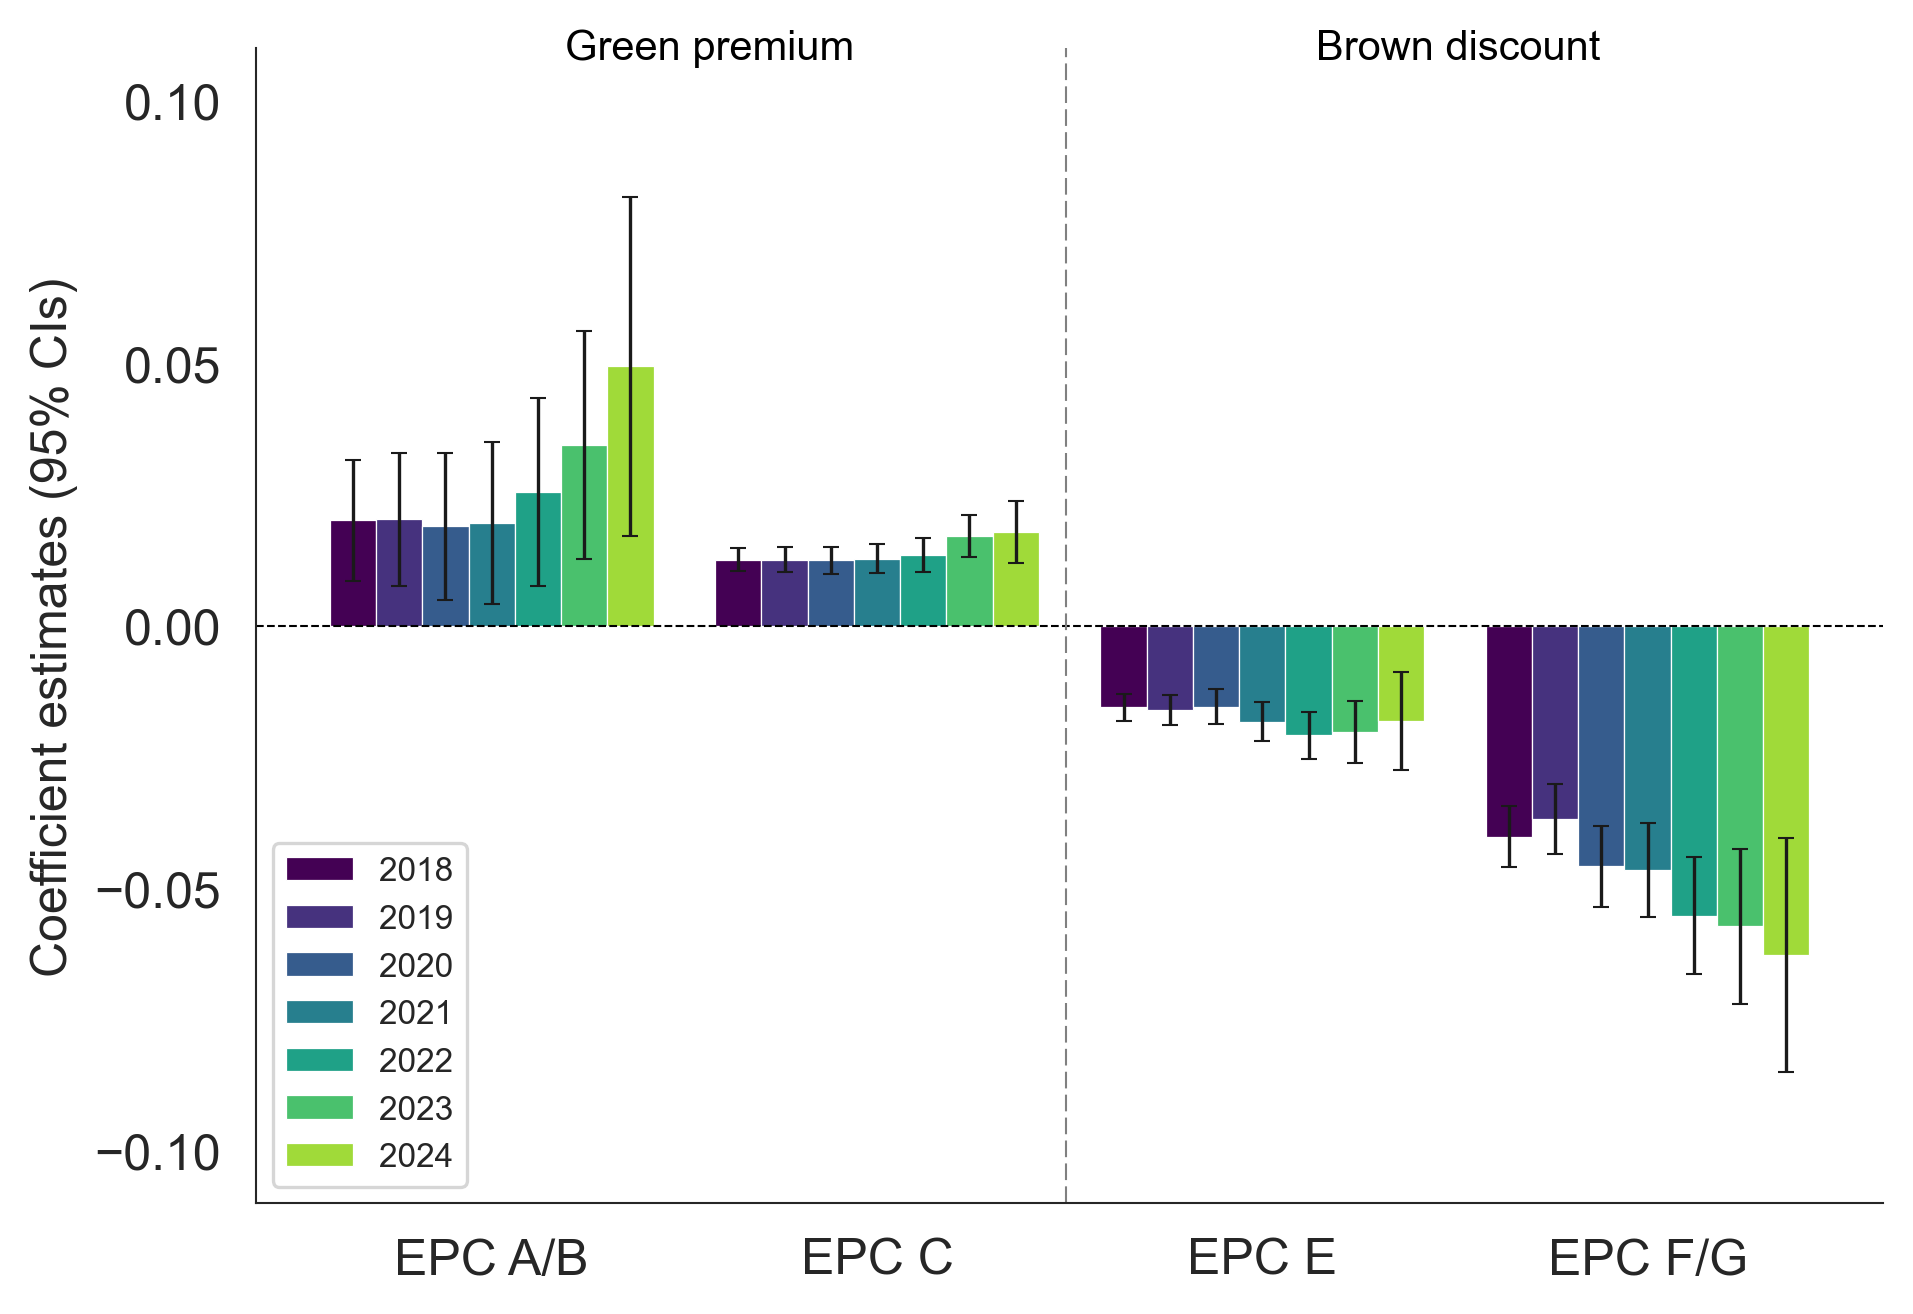

In [452]:
fig, ax = plt.subplots(figsize=(7, 5),dpi=300)

plt.axhline(0, color='black', linestyle='--', lw=0.5)

labels = ['EPC A/B', 'EPC C', 'EPC E', 'EPC F/G']
for spine in ax.spines.values():
    spine.set_linewidth(0.5)

# bar heights
bar_heights = {}
for model in years:
    bar_heights[model] = dfs[dfs['model']==model]['estimate']

# bar CIs
bar_ci = {}
for model in years:
    bar_ci[model] = dfs[dfs['model']==model]['conf_h']

# width of the bars
barWidth = 0.12

# The x position of bars
bar_pos = {}
bar_pos[years[0]] = np.arange(len(labels))
for idx, model in enumerate(years[1:]):
    bar_pos[model] = [x + barWidth*(idx+1) for x in bar_pos[years[0]]]

# Create 7 discrete colors 
cmap = plt.cm.viridis
num_colors = 8
colors = [cmap(i / (num_colors - 1)) for i in range(num_colors)]

# barplots
for idx, model in enumerate(years):
    plt.bar(bar_pos[model], bar_heights[model], width=barWidth, color=colors[idx],
            linewidth=0.3, yerr=bar_ci[model], label=model, 
            error_kw={'elinewidth': 0.8, 'capsize': 2, 'capthick': 0.5})

# Add vertical center line
ax.axvline(x=1.85, color='grey', linestyle=(0, (8, 3)), lw=0.5, )
# Add text
y_center = 0.11
ax.text(1.3, y_center, 'Green premium',
        ha='right', va='center', fontsize=10, color='black')
ax.text(2.5, y_center, 'Brown discount',
        ha='left', va='center', fontsize=10, color='black')

# general layout
plt.ylim(-0.11, 0.11)
plt.xticks([r + 3*barWidth for r in range(len(labels))], labels, fontsize=12)
plt.yticks(fontsize=12)
plt.tick_params(axis='x', width=0.5) 
plt.tick_params(axis='y', width=0.5)
plt.ylabel('Coefficient estimates (95% CIs)', multialignment='center', fontsize=12)
# plt.xlabel('Energy Efficiency Bands', fontsize=12)
plt.legend(fontsize=8,loc='lower left')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Show graphic
plt.show()

# 7. Results visualisatoin

## Model comparison

In [338]:
result_multi.conf_int(alpha=0.05)[0][['epc_mapped_AB','epc_mapped_C','epc_mapped_E',
                     'epc_mapped_FG']]

epc_mapped_AB    0.010952
epc_mapped_C     0.010743
epc_mapped_E    -0.017766
epc_mapped_FG   -0.046565
Name: 0, dtype: float64

In [342]:
def extract_sm_info (result, name):
    df = pd.DataFrame({
        "term": ['epc_mapped_AB','epc_mapped_C','epc_mapped_E',
                     'epc_mapped_FG'],
        "estimate": result.params[['epc_mapped_AB','epc_mapped_C','epc_mapped_E',
                     'epc_mapped_FG']].values,
        'conf.low':result.conf_int(alpha=0.05)[0][['epc_mapped_AB','epc_mapped_C','epc_mapped_E',
                     'epc_mapped_FG']].values,
        'conf.high':result.conf_int(alpha=0.05)[1][['epc_mapped_AB','epc_mapped_C','epc_mapped_E',
                     'epc_mapped_FG']].values,
        "model": name})
    
    return df

In [343]:
results_df = pd.concat([
    extract_sm_info(results, "OLS"),
    extract_sm_info(result_multi, "MLM"),
    pd.DataFrame({
        "term": ['epc_mapped_AB','epc_mapped_C','epc_mapped_E','epc_mapped_FG'],
        "estimate": [0.0223,0.0128,-0.0153,-0.0407],
        'conf.low': [0.0113,0.0106,-0.0179,-0.0462],
        'conf.high':[0.0334,0.0150,-0.0127,-0.0351],
        "model": 'SMLM'})
])

C:\Users\2702471O\AppData\Local\Temp\ipykernel_74748\2910455428.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


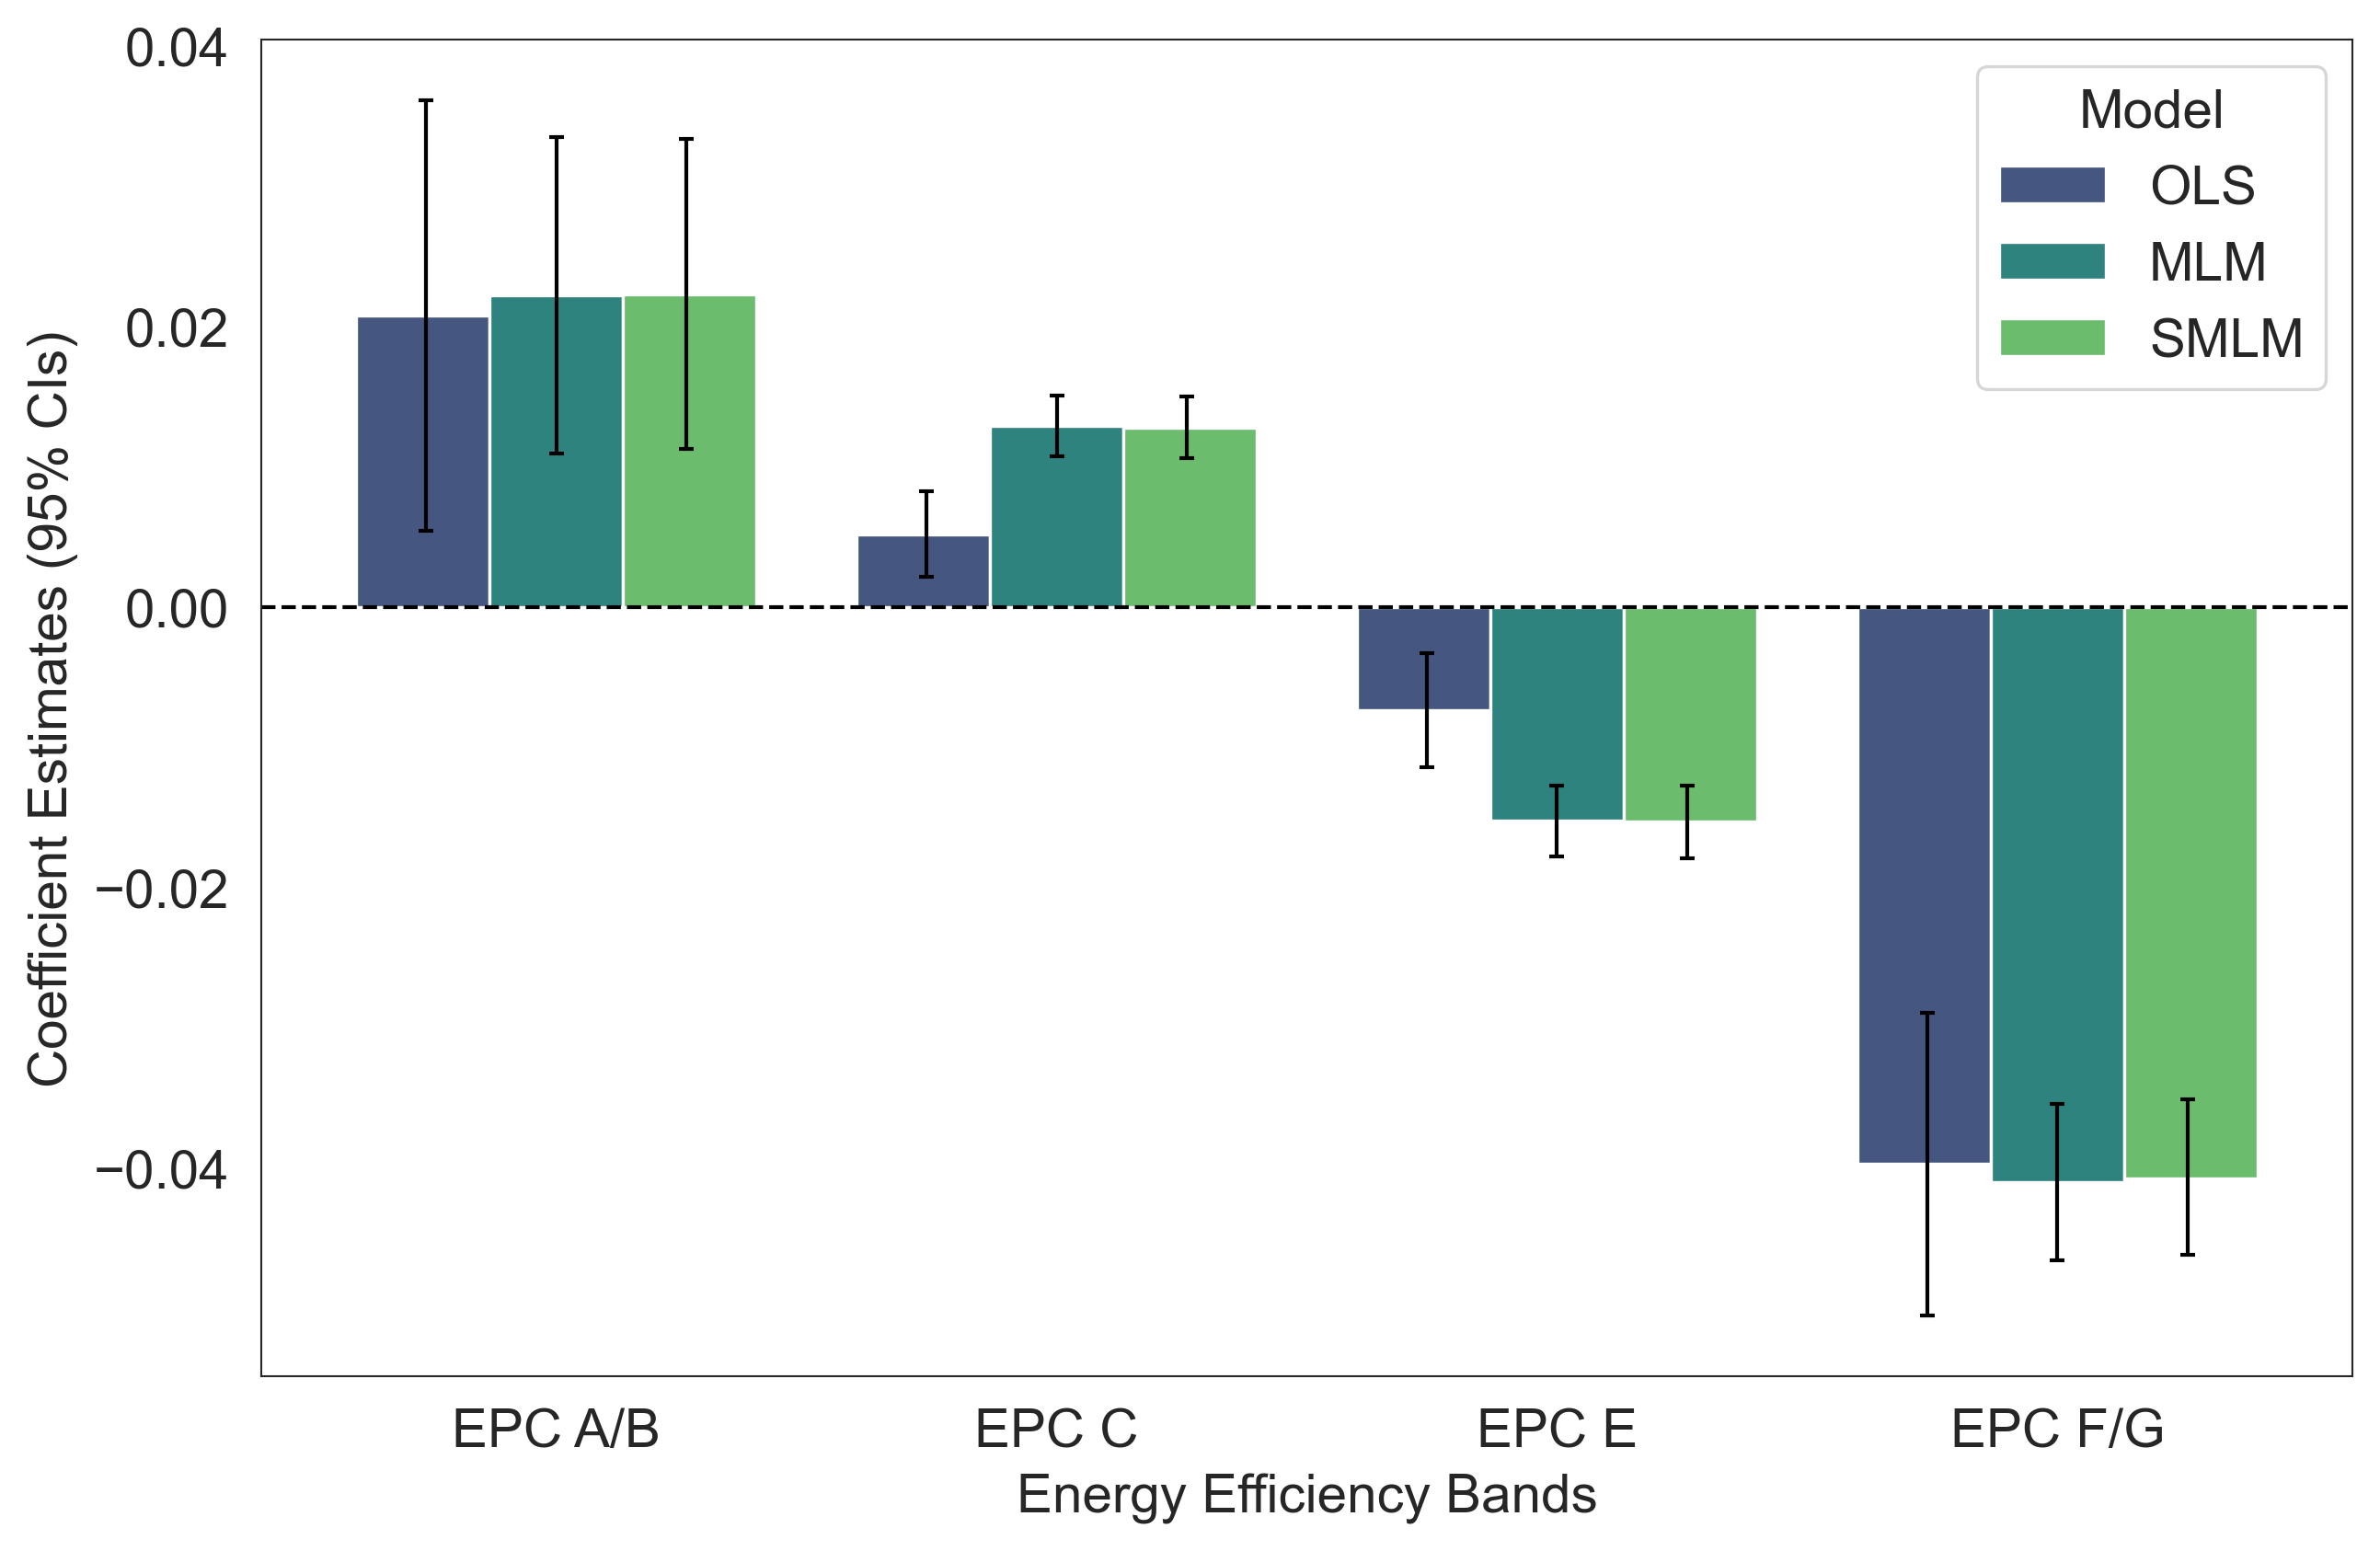

In [355]:
fig,ax = plt.subplots(figsize=(9,6),dpi=300)
# Calculate error bars
results_df['error_low'] =results_df['estimate'] - results_df['conf.low']
results_df['error_high'] = results_df['conf.high'] - results_df['estimate']

# Set style
sns.set_style(style="white")
# sns.set_theme(
#         style="ticks") 

for spine in ax.spines.values():
    spine.set_linewidth(0.5)

# Bar plot with error bars
sns.barplot(
    ax=ax,
    data=results_df,
    x='term', y='estimate', hue='model',
    ci=None, dodge=True, palette='viridis'
)

term_positions = {term: i for i, term in enumerate(results_df['term'].unique())}
width = 0.26
offsets = {'OLS': -width, 'MLM': 0, 'SMLM': width}

for _, row in results_df.iterrows():
    xpos = term_positions[row['term']] + offsets[row['model']]
    ax.errorbar(
        x=xpos, y=row['estimate'],
        yerr=[[row['error_low']], [row['error_high']]],
        fmt='none', capsize=2, color='black', lw=1
    )

plt.axhline(0, color='black', linestyle='--', lw=1)
plt.ylabel("Coefficient Estimates (95% CIs)",fontsize=14)
plt.xlabel("Energy Efficiency Bands",fontsize=14)
plt.xticks(ticks=range(len(term_positions)), labels=['EPC A/B','EPC C','EPC E','EPC F/G'],fontsize=14)
plt.yticks(fontsize=14)
legend = plt.legend(title="Model", fontsize=14)
legend.get_title().set_fontsize('14')
plt.tight_layout()
plt.show()

## Calculate conf_int for interactive var

In [ ]:
terms = ['epc_mapped_AB','epc_mapped_C','epc_mapped_E','epc_mapped_FG']
after_terms = ['After_energy_crisis[T.True]:epc_mapped_AB','After_energy_crisis[T.True]:epc_mapped_C','After_energy_crisis[T.True]:epc_mapped_E',
                     'After_energy_crisis[T.True]:epc_mapped_FG']



In [169]:
# calculate covariance matrix for parameter estimates
cov = result_multi_inter.cov_params()

In [ ]:
combined_var = []
for i,j in zip(terms, after_terms):
    combined_var.append((cov.loc[i,i] + cov.loc[j,j] + 2 * cov.loc[i, j]))

In [ ]:
# confidence interval height (half of length of the error bar) 95% CI using normal distribution - after crisis
inter_conf = np.sqrt(combined_var) * norm.ppf(0.975)

In [211]:
# confidence interval height - before crisis
estimate_conf = (result_multi_inter.conf_int(alpha=0.05)[1][['epc_mapped_AB','epc_mapped_C','epc_mapped_E',
                     'epc_mapped_FG']].values - result_multi_inter.conf_int(alpha=0.05)[0][['epc_mapped_AB','epc_mapped_C','epc_mapped_E',
                     'epc_mapped_FG']].values)/2

## Visualise EPC coefficients before and after crisis

C:\Users\2702471O\AppData\Local\Temp\ipykernel_74748\3922696058.py:81: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  add_pvalue(ax, r1[i], r2[i], bars_before[i], bars_after[i], p_values[i])


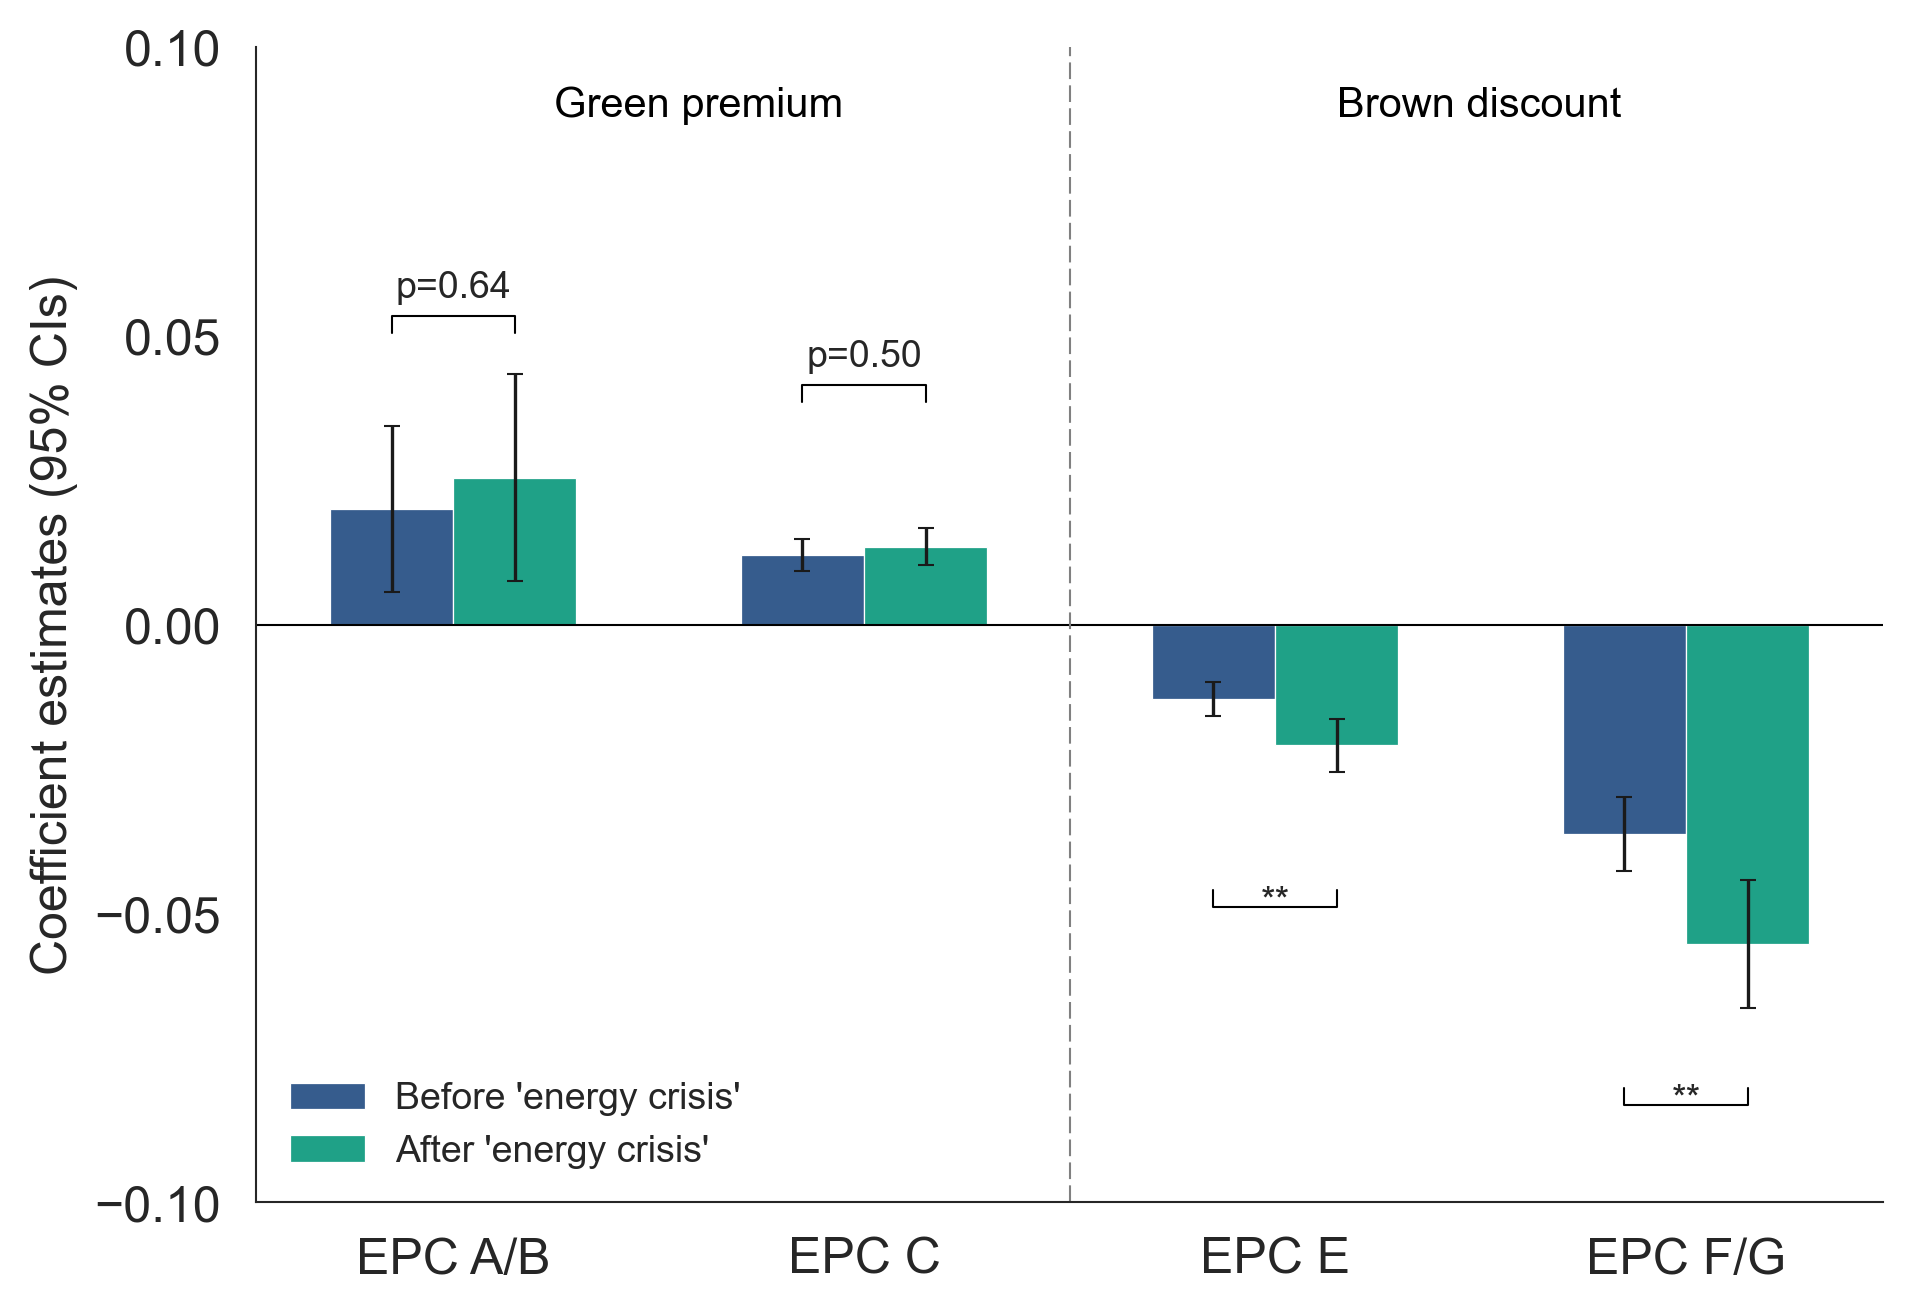

In [454]:
fig, ax = plt.subplots(figsize=(7, 5),dpi=300)

plt.axhline(0, color='black', linestyle='-', lw=0.5)

for spine in ax.spines.values():
    spine.set_linewidth(0.5)

# width of the bars
barWidth = 0.3
 
# Choose the height of the blue bars
bars_before = result_multi_inter.params[terms].values
 
# Choose the height of the cyan bars
bars_after = result_multi_inter.params[after_terms].values+result_multi_inter.params[terms].values
 
# Choose the height of the error bars (bars1)
yer_before = estimate_conf
 
# Choose the height of the error bars (bars2)
yer_after = inter_conf
 
# The x position of bars
r1 = np.arange(len(bars_before))
r2 = [x + barWidth for x in r1]

# Create 7 discrete colors 
cmap = plt.cm.viridis
num_colors = 8
colors = [cmap(i / (num_colors - 1)) for i in range(num_colors)]

# Create before bars
plt.bar(r1, bars_before, width = barWidth, color = colors[2],
        linewidth=0.3, yerr=yer_before, capsize=7, label='Before \'energy crisis\'',
         error_kw={'elinewidth': 0.8, 'capsize': 2, 'capthick': 0.5})
 
# Create after bars
plt.bar(r2, bars_after, width = barWidth, color = colors[4],
        linewidth=0.3, yerr=yer_after, capsize=7, label='After \'energy crisis\'',
        error_kw={'elinewidth': 0.8, 'capsize': 2, 'capthick': 0.5})

# Add vertical center line
ax.axvline(x=1.65, color='grey', linestyle=(0, (8, 3)), lw=0.5, )

# Add text
y_center = 0.09
ax.text(1.1, y_center, 'Green premium',
        ha='right', va='center', fontsize=10, color='black')
ax.text(2.3, y_center, 'Brown discount',
        ha='left', va='center', fontsize=10, color='black')

# Add pvalues
p_values = result_multi_inter.pvalues[after_terms]
def add_pvalue(ax, r1, r2, bars_before, bars_after, pval):
    # Get bar positions and heights
    x1 = r1
    x2 = r2 
    y = max(bars_before, bars_after) if bars_before>0 else min(bars_before, bars_after)

    # Set offset for line height
    line_height = y + 0.025 if y>0 else y - 0.025
    text_height = y + 0.03 if y>0 else y - 0.03

    # Draw line
    ax.plot([x1, x1, x2, x2], [line_height, line_height+0.003 if line_height>0 else line_height-0.003, line_height+0.003 if line_height>0 else line_height-0.003, line_height],
            lw=0.5, c='black')

    # Format p-value text
    if pval < 0.001:
        text = "***"
    elif pval < 0.01:
        text = "**"
    elif pval < 0.05:
        text = "*"
    else:
        text = f"p={pval:.2f}"

    ax.text((x1+x2)/2, text_height, text, ha='center', va='bottom', fontsize=9)

for i in range(len(labels)):
    add_pvalue(ax, r1[i], r2[i], bars_before[i], bars_after[i], p_values[i])

# general layout
plt.ylim(-0.1, 0.1)
plt.xticks([r + barWidth/2 for r in range(len(bars_before))], ['EPC A/B', 'EPC C', 'EPC E', 'EPC F/G'], fontsize=12)
plt.yticks(fontsize=12)
plt.tick_params(axis='x', width=0.5) 
plt.tick_params(axis='y', width=0.5)
plt.ylabel('Coefficient estimates (95% CIs)', multialignment='center', fontsize=12)
# plt.xlabel('Energy Efficiency Bands', fontsize=12)
plt.legend(fontsize=9, loc='lower left',frameon=False)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Show graphic
plt.show()

# 8. Descriptive summary

In [49]:
epc_mapping = {'A':'AB','B':'AB','C':'C','D':'D','E':'E','F':'FG','G':'FG'} 
df_dummy['epc_mapped']  = df_dummy['CURRENT_ENERGY_RATING'].map(epc_mapping)

In [ ]:
variables = ['log_price','tenure_mapped','PROPERTY_TYPE','log_size','rooms_mapped','epc_mapped','BUILT_FORM','age_mapped',
            'modern_kitchen', 'is_garages', 'is_basements', 'is_gardens','income_score','school_quality',
            'log_popden_100','accessibility_PCA1','accessibility_PCA2','year_quarter','LAD21NM', 'After_energy_crisis']

## Full sample

In [62]:
df_existed[['log_price','tenure_mapped','PROPERTY_TYPE','log_size','rooms_mapped','epc_mapped','BUILT_FORM','age_mapped',
            'modern_kitchen', 'is_garages', 'is_basements', 'is_gardens','income_score','school_quality',
            'log_popden_100','accessibility_PCA1','accessibility_PCA2','year_quarter','LAD21NM', 'CURRENT_ENERGY_EFFICIENCY']].describe()

,log_price,log_size,income_score,school_quality,log_popden_100,accessibility_PCA1,accessibility_PCA2,CURRENT_ENERGY_EFFICIENCY
count,170137.000000,170137.000000,170137.000000,170137.000000,170137.000000,170137.000000,170137.000000,170137.000000
mean,12.178904,4.456702,0.146148,2.872779,3.462938,-1.273402,-0.008608,62.344434
std,0.495893,0.277816,0.095251,0.413589,0.831218,4.833506,1.585364,9.903171
min,10.308953,2.995732,0.004000,1.000000,-0.470751,-15.364315,-5.409631,1.000000
25%,11.849362,4.262680,0.066000,2.500000,3.127210,-4.811948,-1.156379,58.000000
50%,12.154779,4.418841,0.123000,3.000000,3.633008,-1.797665,-0.100774,64.000000
75%,12.506177,4.621044,0.211000,3.000000,4.010098,1.650595,1.111314,69.000000
max,14.220976,5.298317,0.545000,4.000000,6.129965,30.761041,6.065732,114.000000


In [57]:
for variable in variables:
    if df_existed[variable].dtype == 'object' or df_existed[variable].dtype == 'bool':
        print(df_existed[variable].value_counts(normalize=True))

tenure_mapped
freehold     0.549551
leasehold    0.450449
Name: proportion, dtype: float64
PROPERTY_TYPE
House       0.9194
Bungalow    0.0806
Name: proportion, dtype: float64
rooms_mapped
5       0.353527
4       0.338897
6-7     0.187925
1-3     0.093478
8-10    0.026173
Name: proportion, dtype: float64
epc_mapped
D     0.546113
C     0.277041
E     0.146817
FG    0.024251
AB    0.005778
Name: proportion, dtype: float64
BUILT_FORM
Terraced         0.425692
Semi-Detached    0.408430
Detached         0.165878
Name: proportion, dtype: float64
age_mapped
1900-1929      0.225883
1930-1949      0.212211
1950-1966      0.158713
1967-1982      0.143167
1983-2002      0.122789
before 1900    0.087418
2003-2011      0.048490
2012-2024      0.001328
Name: proportion, dtype: float64
modern_kitchen
False    0.764284
True     0.235716
Name: proportion, dtype: float64
is_garages
False    0.664288
True     0.335712
Name: proportion, dtype: float64
is_basements
False    0.988027
True     0.011973
Nam

## Subsamples

In [63]:
# after energy crisis
df_existed[df_existed['After_energy_crisis']==True][['log_price','tenure_mapped','PROPERTY_TYPE','log_size','rooms_mapped','epc_mapped','BUILT_FORM','age_mapped',
            'modern_kitchen', 'is_garages', 'is_basements', 'is_gardens','income_score','school_quality',
            'log_popden_100','accessibility_PCA1','accessibility_PCA2','year_quarter','LAD21NM', 'CURRENT_ENERGY_EFFICIENCY']].describe()

,log_price,log_size,income_score,school_quality,log_popden_100,accessibility_PCA1,accessibility_PCA2,CURRENT_ENERGY_EFFICIENCY
count,62086.000000,62086.000000,62086.000000,62086.000000,62086.000000,62086.000000,62086.000000,62086.000000
mean,12.360196,4.465445,0.144039,2.870478,3.451101,-1.343399,-0.029236,63.711127
std,0.452757,0.280158,0.094681,0.416958,0.829814,4.771501,1.571774,9.291030
min,10.341742,2.995732,0.006000,1.000000,-0.470751,-15.364315,-5.409631,1.000000
25%,12.043554,4.262680,0.063000,2.500000,3.112670,-4.830876,-1.168768,59.000000
50%,12.345835,4.430817,0.121000,3.000000,3.629328,-1.856937,-0.123817,66.000000
75%,12.644328,4.634729,0.208000,3.000000,4.000259,1.494853,1.078785,70.000000
max,14.220976,5.298317,0.545000,4.000000,6.129965,30.761041,6.065732,114.000000


In [59]:
for variable in variables:
    if df_existed[variable].dtype == 'object' or df_existed[variable].dtype == 'bool':
        print(df_existed[df_existed['After_energy_crisis']==True][variable].value_counts(normalize=True))

tenure_mapped
freehold     0.564411
leasehold    0.435589
Name: proportion, dtype: float64
PROPERTY_TYPE
House       0.922913
Bungalow    0.077087
Name: proportion, dtype: float64
rooms_mapped
5       0.361144
4       0.328142
6-7     0.194472
1-3     0.088861
8-10    0.027381
Name: proportion, dtype: float64
epc_mapped
D     0.521808
C     0.339094
E     0.116532
FG    0.016429
AB    0.006137
Name: proportion, dtype: float64
BUILT_FORM
Semi-Detached    0.417034
Terraced         0.413330
Detached         0.169636
Name: proportion, dtype: float64
age_mapped
1900-1929      0.217022
1930-1949      0.215669
1950-1966      0.161147
1967-1982      0.147731
1983-2002      0.126035
before 1900    0.079744
2003-2011      0.049270
2012-2024      0.003382
Name: proportion, dtype: float64
modern_kitchen
False    0.767258
True     0.232742
Name: proportion, dtype: float64
is_garages
False    0.668234
True     0.331766
Name: proportion, dtype: float64
is_basements
False    0.987485
True     0.012515

In [65]:
# before energy crisis
df_existed[df_existed['After_energy_crisis']==False][['log_price','tenure_mapped','PROPERTY_TYPE','log_size','rooms_mapped','epc_mapped','BUILT_FORM','age_mapped',
            'modern_kitchen', 'is_garages', 'is_basements', 'is_gardens','income_score','school_quality',
            'log_popden_100','accessibility_PCA1','accessibility_PCA2','year_quarter','LAD21NM', 'CURRENT_ENERGY_EFFICIENCY']].describe()

,log_price,log_size,income_score,school_quality,log_popden_100,accessibility_PCA1,accessibility_PCA2,CURRENT_ENERGY_EFFICIENCY
count,108051.000000,108051.000000,108051.000000,108051.000000,108051.000000,108051.000000,108051.000000,108051.000000
mean,12.074733,4.451678,0.147359,2.874101,3.469739,-1.233182,0.003245,61.559134
std,0.489579,0.276337,0.095556,0.411638,0.831952,4.868344,1.593006,10.155539
min,10.308953,2.995732,0.004000,1.000000,-0.470751,-15.364315,-5.409631,1.000000
25%,11.736069,4.262680,0.066000,2.500000,3.135668,-4.779631,-1.154692,57.000000
50%,12.043554,4.418841,0.125000,3.000000,3.634039,-1.780334,-0.092340,63.000000
75%,12.409013,4.615121,0.213000,3.000000,4.014560,1.657117,1.137192,68.000000
max,14.220976,5.298317,0.545000,4.000000,6.129965,30.761041,6.065732,104.000000


In [61]:
for variable in variables:
    if df_existed[variable].dtype == 'object' or df_existed[variable].dtype == 'bool':
        print(df_existed[df_existed['After_energy_crisis']==False][variable].value_counts(normalize=True))

tenure_mapped
freehold     0.541013
leasehold    0.458987
Name: proportion, dtype: float64
PROPERTY_TYPE
House       0.917382
Bungalow    0.082618
Name: proportion, dtype: float64
rooms_mapped
5       0.349150
4       0.345078
6-7     0.184163
1-3     0.096131
8-10    0.025479
Name: proportion, dtype: float64
epc_mapped
D     0.560078
C     0.241386
E     0.164219
FG    0.028746
AB    0.005571
Name: proportion, dtype: float64
BUILT_FORM
Terraced         0.432796
Semi-Detached    0.403485
Detached         0.163719
Name: proportion, dtype: float64
age_mapped
1900-1929      0.230974
1930-1949      0.210225
1950-1966      0.157315
1967-1982      0.140545
1983-2002      0.120924
before 1900    0.091827
2003-2011      0.048042
2012-2024      0.000148
Name: proportion, dtype: float64
modern_kitchen
False    0.762575
True     0.237425
Name: proportion, dtype: float64
is_garages
False    0.662021
True     0.337979
Name: proportion, dtype: float64
is_basements
False    0.988339
True     0.011661